<div class="alert alert-success">.
<span style=" font-size: 4em; "><center>FYTH - VAST challenge</center></span>
.
</div>

<div class="alert alert-success"><span style=" font-size: 2em; "><center> Assignment 2<br> <br>_Story of Assignment 1 and visualization of bird sound files_</center></span></div>

To-do:
<ul>
    <li>Turn your visualizations from Assignment 1 into a report (e.g. Doc file) explaining what you have found so far and what your next steps might be to answer the mini challenge.</li>
    <li>Visualize a sound file as a signal</li> 
    <li>Collect a list of methods to classify bird sound from the literature, starting from e.g. Automated bird sound recognition in realistic settings and its references.</li>
    <li>Visualize multiple audio signals and their 2D spectrograms to facilitate visual inspection and comparison</li>
    <li>  Although automated classification can be applied to Kasios sound files, find some visual features that can be highlighted in the visualization to help understand the most important features for discriminating bird sounds? You don't need to be 100% successful of course.</li>
</ul>


- <a href="#1">1 - Results of the first assignement</a> (The report of the assignment 1 is available [here](https://github.com/zhufangda/Telecom_Paristech-3rd_year/blob/master/DATA920_Visualization/2018%20Mini-Challenge%201/Solution/Assignment1_Report.pdf))
- <a href="#Sounds-file-preprocessing">2 - Sounds file preprocessing and first visualizations</a>
- <a href="#Create-features-step-by-step">3 - Create features</a>
- <a href="#Scalability">4 - Scalability</a>
- <a href="#Compare-differents-species">5 - Compare different species</a>
- <a href="#Kasios-records">6 - Kasios records and classification</a>

<div style="text-align: right"> <a href="#1" class="btn btn-success">Result of the first part</a></div>

In [1]:
%matplotlib inline
import pandas as pd
#import warnings
#warnings.filterwarnings("ignore")

In [2]:
# our vast librairy
import vast as vst

In [3]:
from pydub import AudioSegment

In [4]:
import os
import re

In [5]:
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import statistics
import librosa
import heapq

In [6]:
#visualization
from ipywidgets import IntProgress
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns 

In [7]:
path = "https://github.com/zhufangda/Telecom_Paristech-3rd_year/raw/master/"\
        +"DATA920_Visualization/2018%20Mini-Challenge%201/"

# Results of the first assignement

In [8]:
# vectorize the map
map_contours = vst.vectorize(path + "lekagul_roadways_2018.png")

In [9]:
path = "https://github.com/zhufangda/Telecom_Paristech-3rd_year/raw/master/"\
        +"DATA920_Visualization/2018%20Mini-Challenge%201/"

In [10]:
# read the file 
data = pd.read_csv(path + "AllBirdsv4.csv", parse_dates=[5], dayfirst=True)

In [11]:
cat_bird = pd.Categorical(data['English_name'],ordered=False)
i_bp = cat_bird.categories.tolist().index('Rose-crested Blue Pipit')

In [12]:
nb_categories = len(cat_bird.categories.unique())

In [13]:
# Add a column with 1 for the Blue pipits else 0
data['IsRCBP'] = data['English_name'].apply(lambda x: 1 \
                                            if x=="Rose-crested Blue Pipit"\
                                            else 0)

In [14]:
# clean vocalization
# all in lower string
data['Vocalization_type'] = data['Vocalization_type'].apply(str.lower)
# delete spaces
data['Vocalization_type'] = data['Vocalization_type'].apply(str.strip)

In [15]:
# clean the grids 
# returns -1 if not possible to select a number beetween 0 and 200
data['X'] = data['X'].apply(vst.clean_grid)
data['Y'] = data['Y'].apply(vst.clean_grid)

In [16]:
kasios_records = pd.read_csv(path + "Test_Birds_Location.csv")

In [17]:
kasios_records = kasios_records.rename(index=str, columns={" X": "X", " Y":"Y"})

In [18]:
def plotmap():
    fig, ax = plt.subplots(figsize=(10,10))
    # print the map
    vst.print_map(ax, map_contours, "All record locations")
    # plot Blue pipits
    ax.scatter(data.loc[data['IsRCBP']== 1]['X'], 
               data.loc[data['IsRCBP']== 1]['Y'],
               color='blue', alpha=0.7, label="Blue Pipit location")
    # plot others
    ax.scatter(data.loc[data['IsRCBP']== 0]['X'], 
               data.loc[data['IsRCBP']== 0]['Y'],
               color='green', alpha=0.2, label="Other birds location")

    # Add Kasios records with ID
    for i, txt in enumerate(kasios_records['ID'].values):
        ax.text(kasios_records['X'].values[i], kasios_records['Y'].values[i], 
                txt, color='black', ha="center", va="center", 
                bbox={'pad':0.4, 'boxstyle':'circle', 
                      'edgecolor':'none', 'facecolor':'orange'})

    ax.scatter([], [], color='orange', marker='o',s=100, label='Kasios records')
    ax.legend(bbox_to_anchor=(1, 1), labelspacing=1)
    plt.show()

<a id='1'></a>

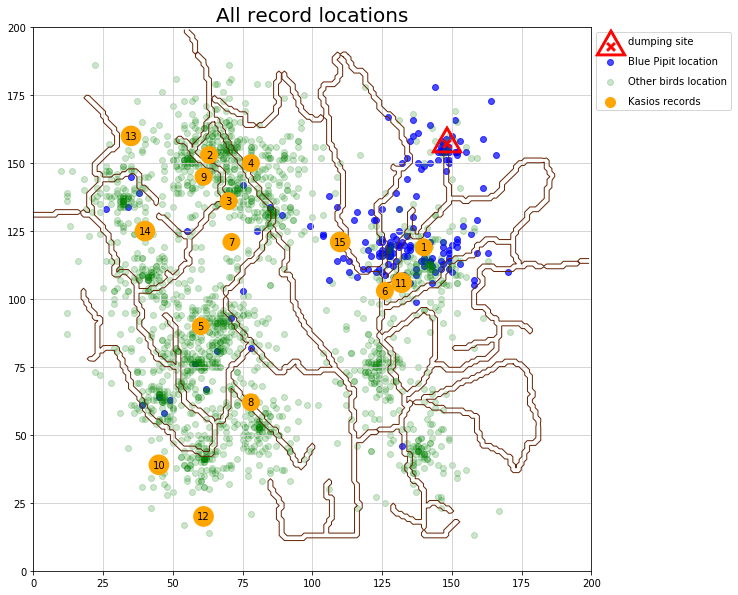

In [19]:
plotmap()

<div class="alert alert-success">
** Main conclusions of the first assignment**
<br>
We have enough records to keep only good quality and call&songs sounds.
<br>
Blue Pipits nest or have nested IVO the dumping site
<br>
We now have to check if Kasios records are Blue Pipit records, escpecially records #1, #11, #6 and #15
</div>

<div style="text-align: right"> <a href="#2" class="btn btn-success">Remove poor quality files</a></div>

# Sounds file 

## Sounds file preprocessing

In [20]:
len(data)

2081

### Remove all non usefull data

In [21]:
# delete all useless data : keep only good quality, call and songs
data_sounds = data.loc[data['Quality'] <= 'C']
data_sounds = data_sounds.loc[data.Vocalization_type.isin(['song' , 'call','call, song'])]

In [22]:
len(data_sounds)

1893

In [23]:
cat_bird2 = pd.Categorical(data_sounds['English_name'],ordered=False)

In [24]:
def plot_new_distribub():
    fig = plt.subplots(figsize=(12,5))
    ax = cat_bird2.value_counts().plot(kind='bar', color='#009432', 
                                      label='Other birds', zorder = 2)
    ax.get_children()[16].set_color('#0652DD')
    ax.get_children()[16].set_label('Blue Pipits')
    plt.xticks(rotation=30, ha='right')
    plt.ylabel("# of records", fontsize=12)
    ax.legend()
    ax.grid(which='major', axis='y', linestyle='--', zorder=1)
    plt.title("Distribution of the records by bird category while selecting call, songs and ABC quality", fontsize=16)
    plt.show()

<a id='2'></a>

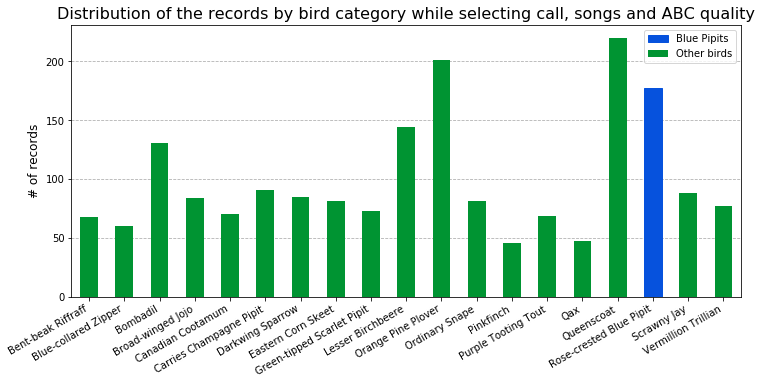

In [25]:
plot_new_distribub()

<div class="alert alert-success">
We have enough samples to perform ML (1893 samples, more than 170 blue pipits)
</div>

<div style="text-align: right"> <a href="#3" class="btn btn-success">Open and read a sound file</a></div>

### First visualizations

<a id='3'></a>

#### Transform the mp3 into wav

In [26]:
#transform mp3 into wav
sound = AudioSegment.from_mp3("Sounds/test3.mp3")
sound = sound.set_frame_rate(44100)
sound = sound.set_channels(1)

sound.export("Sounds/test.wav", format="wav")

<_io.BufferedRandom name='Sounds/test.wav'>

In [27]:
# open the wav file 
rate, samples = wavfile.read("Sounds/test.wav")

In [28]:
print(rate) ## nb frames per second

44100


<div class="alert alert-success">
- Use wav file (uncompressed)
<br>
- Standardize the frequency rate to 44100Hz
<br>
- Keep only one channel (stereo to mono)
</div>

<div style="text-align: right"> <a href="#4" class="btn btn-success">First visualization</a></div>

In [29]:
print(samples.shape)

(5328000,)


In [30]:
n_samples = len(samples)

#### From stereo to mono

In [31]:
# if stereo, keep only one channel
if samples.ndim == 2:
    samples = samples[:,0]

#### Plot the whole sound file : magnitude and spectrogram

In [32]:
def log_specgram(audio, sample_rate, window_size=20, step_size=10, eps=1e-10):
    """
    This function
    """
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, 10 * np.log10(spec.T.astype(np.float32) + eps)

In [33]:
freqs, times, spectrogram = log_specgram(samples, rate)

In [34]:
def plot_magnitude_spectrogram(samples, rate, freqs, times, spectrogram):
    n_sample = len(samples)
    fig = plt.figure(figsize=(14, 8))
    ax1 = fig.add_subplot(211)
    ax1.set_title('Raw wave')
    ax1.set_ylabel('Magnitude')
    ax1.set_xlim(times.min(), times.max())
    ax1.plot(np.linspace(0, n_sample / rate, n_sample), samples, color='#ff7f00', linewidth=0.05)

    ax2 = fig.add_subplot(212)
    ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
               extent=[times.min(), times.max(), freqs.min(), freqs.max()], cmap='autumn_r')
    ax2.set_title('Spectrogram ')
    ax2.set_ylabel('Freqs in Hz')
    ax2.set_xlabel('Seconds')
    plt.show()

<a id='4'></a>

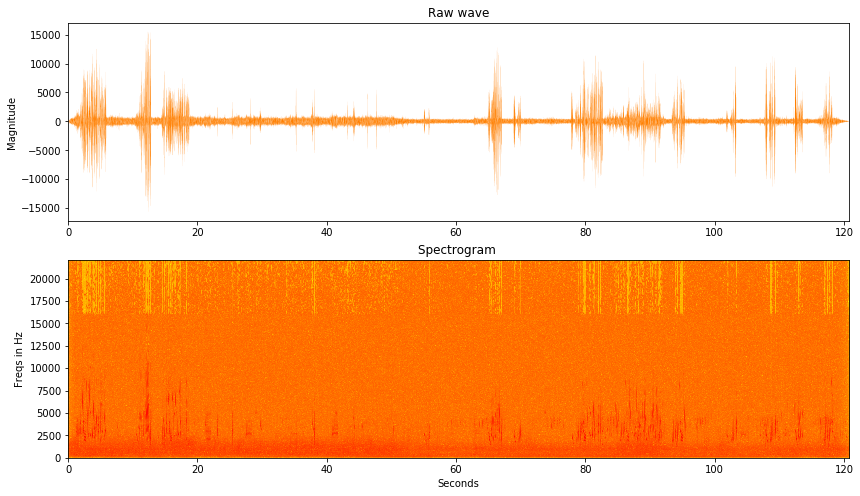

In [35]:
plot_magnitude_spectrogram(samples, rate, freqs, times, spectrogram)

<div class="alert alert-success">
- Need to normalize timely and powerly 
<br>
- Noises and silencies could be deleted
<br>
- Difficult to compare different records with this kind of graph
</div>


<div style="text-align: right"> <a href="#5" class="btn btn-success">Another visualization</a></div>

#### Visualize the FFT of the sound

In [36]:
def custom_fft(y, fs):
    """
    Calculate the FFT of the samples y with a rate of fs
    """
    T = 1.0 / fs
    N = y.shape[0]
    yf = fft(y)
    xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
    power = 10 * np.log10(2.0/N * np.abs(yf[0:N//2]))  # FFT is simmetrical, so we take just the first half
    # FFT is also complex, to we take just the real part (abs)
    return xf, power

In [37]:
def plot_fft(fourier, power):
    plt.figure(figsize=(14,6))
    plt.plot(fourier/1000, power, color='#ff7f00', linewidth=0.05)
    plt.xlabel('Frequency (kHz)', fontsize = 16)
    plt.ylabel('Power (dB)', fontsize = 16)
    plt.show()

In [38]:
fourier, power = custom_fft(samples, rate)

<a id='5'></a>

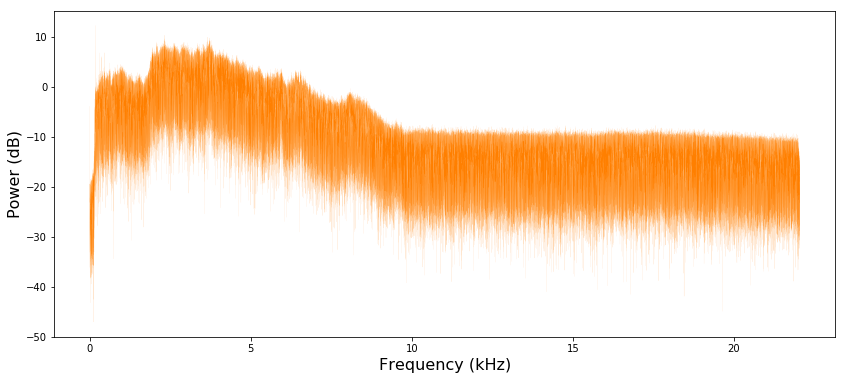

In [39]:
plot_fft(fourier, power)

<div class="alert alert-success">
Advantage of this graph : do not depend of the lenght of the sound file.
<br>
We have to have at least three dimensions to characterize the sound file : **time, frequency and power**.
</div>

<div style="text-align: right"> <a href="#6" class="btn btn-success">Create feature step 1</a></div>

## Create features step by step

Using the conclusions of T Papadopoulos, S.J. Roberts, K. Willis, _Automated bird sound recognition in realistic settings_, Sep.2018


<a id='6'></a>

### Step 1: select the most energetic frames

<div class="well">
"Namely, for each recording we identify the **1% most energetic frames** and we take the **mean energy** of those frames as an estimate of highest level for that particular recording. Following that, **we select all frames of that recording that have power of at least 0.25** of the estimated highest level as corresponding to bird sound and discard the remaining frames."
<br>    
T Papadopoulos, S.J. Roberts, K. Willis, _Automated bird sound recognition in realistic settings_, Sep.2018

</div>

<div style="text-align: right"> <a href="#7" class="btn btn-success">Visualize result of step 1</a></div>

In [41]:
# mean of the 1% most energetic samples 
mean_high_NRJ_samples = np.mean(heapq.nlargest(n_samples//100, np.abs(samples)))
# select only samples of that recording that have power of at least 0.25 of the estimated highest level
samples = np.array([sample for i_sample, sample in enumerate(samples) if np.abs(sample) > 0.25 * mean_high_NRJ_samples])
# update nb frames
n_samples = len(samples)

In [42]:
freqs, times, spectrogram = log_specgram(samples, rate)
fourier, power = custom_fft(samples, rate)

<a id='7'></a>

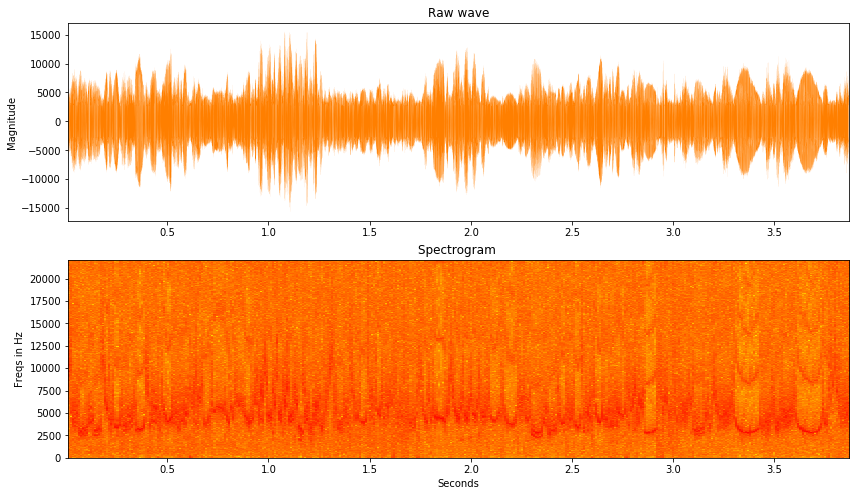

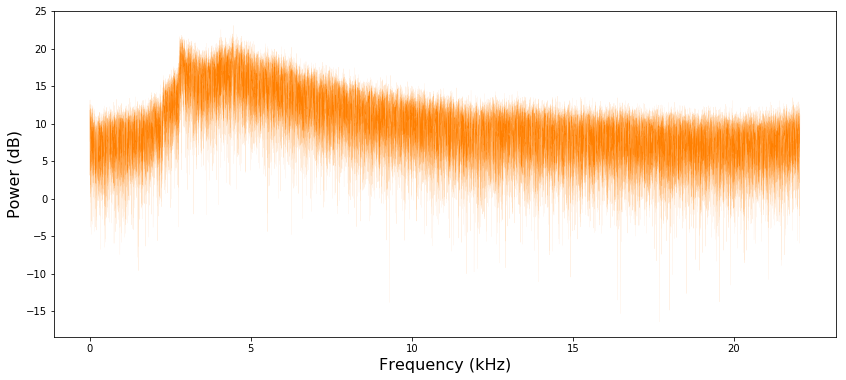

In [43]:
plot_magnitude_spectrogram(samples, rate, freqs, times, spectrogram)
plot_fft(fourier, power)

<div class="alert alert-success">
This step allows removing some noise and all silencies. 
<br>
Moreover, the lenght (and consequently the size of the file) is reduced from 120s to 4s...
</div>

<div style="text-align: right"> <a href="#8" class="btn btn-success">Create feature next step</a></div>

<a id='8'></a>

### Step 2: split into 20ms frames

<div class="well">
"The features we extract are based on FFT-based spectrograms. The spectrogram of each of the training and test recording is computed with a **frame length of 20ms, overlap of 50% ** and rectangular window."
    
<br>    
T Papadopoulos, S.J. Roberts, K. Willis, _Automated bird sound recognition in realistic settings_, Sep.2018

</div>

<div class="alert alert-success">
The overlapping keep the time component
</div>

<div style="text-align: right"> <a href="#9" class="btn btn-success">Create Features Next step</a></div>

Already done with the function log_specgram(audio, sample_rate, window_size=20, step_size=10, eps=1e-10)

In [44]:
window_size=20
step_size=10

<a id='9'></a>

### Step 3: Keep only 1-10KHz

<div class="well">
"In order to minimize the contribution of low frequency wind noise in the recordings, **only the bins corresponding to 

frequencies between 1kHz and 10kHz are kept**. Those frequency limits are within the range of what is typically used in existing bird recognition studies and slight changes around these values should not be expected to have a
considerable effect on the system’s performance "
    
<br>    
T Papadopoulos, S.J. Roberts, K. Willis, _Automated bird sound recognition in realistic settings_, Sep.2018

</div>

<div class="alert alert-success">
According to specialists, many bird songs have frequency ranges between  1 and 8 kHz, with maximum sensitivity between 1 and 5 kHz
</div>

<div style="text-align: right"> <a href="#11" class="btn btn-success">Create feature next step</a></div>

In [45]:
# keep only fq between 1kHz and 10 kHz
indices = [i for i, fq in enumerate(freqs) if fq>1000 and fq<10000]
freqs_red = freqs[indices]
spectrogram_red = spectrogram[:,indices]

<a id='11'></a>

### Step 4: normalize

<div class="well">
" Four types of frame-level features were considered, all choices from the various types described in Briggs et al.
(2009) and Stowell & Plumbley (2014a). More specifically, after **normalising the absolute value of each frame’s spectrum to sum unity**, we computed the mean (denoted here as f mean ), standard deviation (f std ), mode (f mode ) and the difference between the mode of each selected frame and its successor in the original recording "
    
<br>    
T Papadopoulos, S.J. Roberts, K. Willis, _Automated bird sound recognition in realistic settings_, Sep.2018

</div>

<div style="text-align: right"> <a href="#12" class="btn btn-success">Visualize the result</a></div>

In [46]:
from sklearn.preprocessing import normalize

In [47]:
sequence_spectogram_normalized = normalize(spectrogram_red, norm="l1", axis=1)

<a id='12'></a>

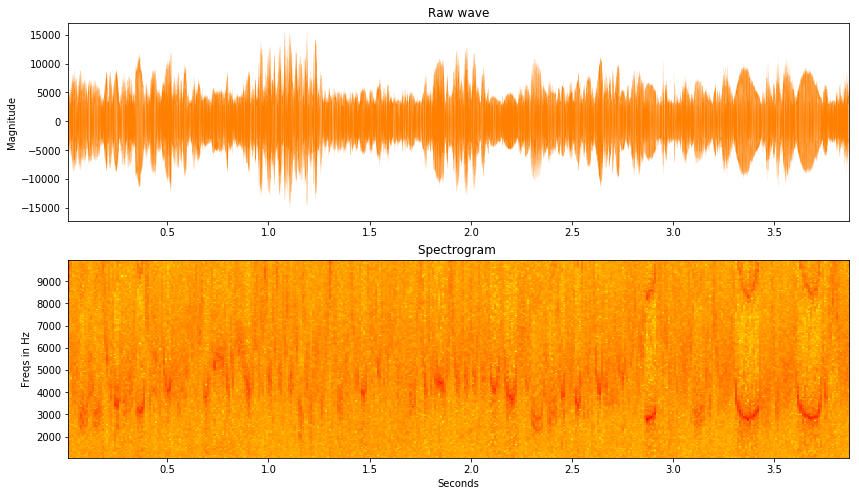

In [48]:
plot_magnitude_spectrogram(samples, rate, freqs_red, times, sequence_spectogram_normalized)

<div class="alert alert-success">
NSTR
</div>

<div style="text-align: right"> <a href="#13" class="btn btn-success">Create Features next step</a></div>

<a id='13'></a>

### Step 5: Concatene and compute sequence of 100 frames

<div class="well">
"the individual sequences of frame-level features
from each **recording of the same species are lined-up in one sequence** (which
preserves the original frame sequence in each audio recording but contains ‘cuts’
due to rejected frames and due to the line-up of the different recordings) and
**sequences of features obtained from 100 frames** are taken."
<br>    
T Papadopoulos, S.J. Roberts, K. Willis, _Automated bird sound recognition in realistic settings_, Sep.2018

</div>

<div class="alert alert-success">
The lenght of each sequence is 2ms 
</div>

<div style="text-align: right"> <a href="#14" class="btn btn-success">Visualize the result</a></div>

In [49]:
def get_sequences(spectrogram, l_sequence=100, tolerance=0.3):
    nb_frames = len(spectrogram)
    list_sequences = []
    nb_sequences = nb_frames // l_sequence

    if nb_sequences != 0:
        for j in range(nb_sequences - 1):
            list_sequences.append(spectrogram[j * l_sequence: (j+1) * l_sequence])
    else:
        # we have less than n_frames_per_sequence in the frame...
        # overlap the last sequence if there is sufficient information
        if (nb_frames % l_sequence > l_sequence * tolerance):
            list_sequences.append(spectrogram[-l_sequence:])

    return list_sequences

In [50]:
list_sequences = get_sequences(sequence_spectogram_normalized)

In [51]:
sequence_spectogram_normalized = list_sequences[0]

In [52]:
def plot_spectrogram(freqs, times, spectrogram):
    n_sample = len(samples)
    fig = plt.figure(figsize=(14, 4))
    plt.imshow(spectrogram.T, extent=[0, 100, freqs.min(), freqs.max()], aspect='auto', origin='lower', cmap='autumn_r')
    plt.title('Spectrogram ')
    plt.ylabel('Freqs in Hz')
    plt.xlabel('Nb frames')
    plt.show()

<a id='14'></a>

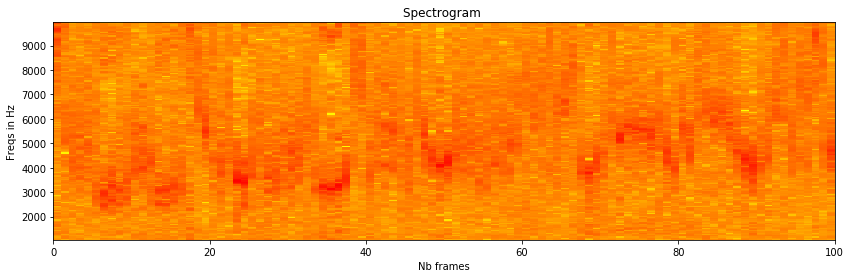

In [53]:
plot_spectrogram(freqs_red, times, sequence_spectogram_normalized)

<div class="alert alert-success">
This sequence is now standardized, and represent a good baseline.
</div>

<div style="text-align: right"> <a href="#15" class="btn btn-success">Create feature next step</a></div>

<a id='15'></a>

### Step 6: create features

<div class="well">
" We consider three types of binned histograms: 
<ul class="list">
  <li class="list-item">
two-dimensional histograms of the f_mean and f_std frame-level features with 100 and 50 bins spaced uniformly from 1kHz to 10kHz along the two respective dimensions (corresponding to 5000-dimensional feature vectors)  
</li>
 <li class="list-item">
one-dimensional histograms of the f_mode feature with 100 bins spaced uniformly from 1kHz to 10kHz along the f mode dimension (corresponding to 100-dimensional feature vectors)
</li> 
<li class="list-item">
two-
dimensional histograms of the f_mode and Δf mode pair of features with 100 bins
spaced uniformly from 1kHz to 10kHz along the f mode dimension and 50 bins
spaced uniformly from -2kHz to 2kHz along the Δf mode dimension (corresponding
to 5000-dimensional feature vectors).
</li>
</ul> 
T Papadopoulos, S.J. Roberts, K. Willis, _Automated bird sound recognition in realistic settings_, Sep.2018

</div>


$$ f_{mean}(i) = \int \text{spec}(f_i).f_i .\partial f_i$$
$$ f_{std}(i) = \sqrt{\int \text{spec}(f_i) (f_i - f_{mean})^2\partial f_i}$$
$$ f_{mode}(i) = f_i(F)\text{ , with F} = \arg\max \text{spec}(f_i)$$
$$ f_{\Delta mode}(i) = f_{mode} (i) - f_{mode} (i-1)$$


<div class="alert alert-success">
$\Delta mode$ allows keeping time aspect
</div>

<div style="text-align: right"> <a href="#16" class="btn btn-success">Visualize features</a></div>

In [54]:
# Create edges for the histograms from e_min to e_max
def edges(e_min, e_max, nb_bins):
    return np.arange(e_min, e_max + (e_max-e_min) / nb_bins, (e_max-e_min) / nb_bins)

f_mean_edges = edges(1000, 10000, 100)
f_std_edges = edges(1000, 4000, 50)
f_mode_edges = edges(1000, 10000, 100)
f_delta_mode_edges = edges(-2000, 2000, 50)

In [55]:
n_frames_sequence = min(sequence_spectogram_normalized.shape[0], 100)

In [56]:
# calculate mean, std, mode and delta_mode
f_mean = [np.sum(freqs_red * sequence_spectogram_normalized[i]) for i in range(n_frames_sequence)]
f_std = [(np.abs(np.sum(sequence_spectogram_normalized[i] * ((freqs_red - f_mean[i]) ** 2) ))) ** (0.5) for i in range(n_frames_sequence)]
f_mode = [freqs_red[np.argmax(sequence_spectogram_normalized[i])] for i in range(n_frames_sequence)]
f_delta_mode = np.roll(f_mode, -1) - f_mode

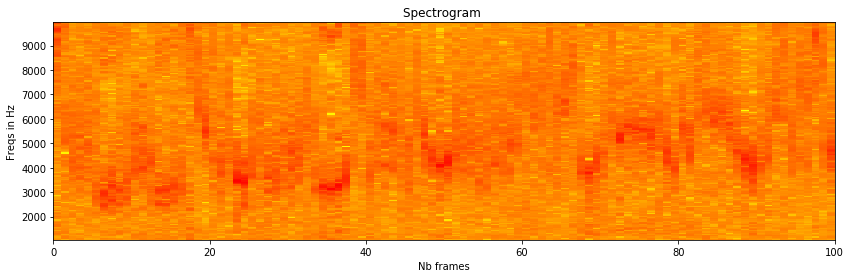

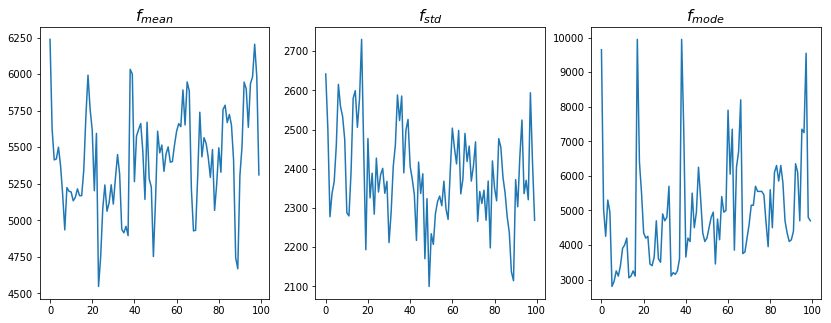

In [57]:
plot_spectrogram(freqs_red, times, sequence_spectogram_normalized)
fig, axs = plt.subplots(1, 3, figsize=(14, 5))
axs[0].plot(range(len(f_mean)),f_mean)
axs[0].set_title("$f_{mean}$", fontsize=16)
axs[1].plot(range(len(f_std)),f_std)
axs[1].set_title("$f_{std}$", fontsize=16)
axs[2].plot(range(len(f_mode)),f_mode)
axs[2].set_title("$f_{mode}$", fontsize=16)
plt.show()

In [58]:
# create histogramms
sequence_histogram1, f_mean_edges, f_std_edges = np.histogram2d(f_mean, f_std, bins=(f_mean_edges, f_std_edges))
sequence_histogram1 = sequence_histogram1.T
sequence_histogram2, f_mode_edges = np.histogram(f_mode, bins=f_mode_edges)
sequence_histogram3, f_mode_edges, f_delta_mode_edges = np.histogram2d(f_mode, f_delta_mode, bins=(f_mode_edges, f_delta_mode_edges))
sequence_histogram3 = sequence_histogram3.T

In [59]:
def plot_features(category, sequence, freq_red,
                  f_mean_edges = edges(1000, 10000, 100),
                  f_std_edges = edges(1000, 4000, 50),
                  f_mode_edges = edges(1000, 10000, 100),
                  f_delta_mode_edges = edges(-2000, 2000, 50),
                  n_frames_per_sequence=100):
    """
    """
    l_sequence = len(sequence)
    if l_sequence < n_frames_per_sequence:
        n_frames_per_sequence = l_sequence
            
    f_mean = [np.sum(freqs_red * sequence[i]) for i in range(n_frames_per_sequence)]
    f_std = [(np.abs(np.sum(sequence[i] * (freqs_red -f_mean[i]) **2 ))) ** (0.5) for i in range(n_frames_per_sequence)]
    f_mode = [freqs_red[np.argmax(sequence[i])] for i in range(n_frames_sequence)]
    f_delta_mode = np.roll(f_mode, -1) - f_mode

    H1, _, _ = np.histogram2d(f_mean, f_std, bins=(f_mean_edges, f_std_edges))
    H2, _ = np.histogram(f_mode, bins=f_mode_edges)
    H3, _, _ = np.histogram2d(f_mode, f_delta_mode, bins=(f_mode_edges, f_delta_mode_edges))
    
    fig, axs = plt.subplots(1, 3, figsize=(14, 5))
    axs[0].imshow(H1.T,interpolation='nearest', origin='low', extent=[f_mean_edges[0], f_mean_edges[-1], f_std_edges[0], f_std_edges[-1]])
    axs[0].set_xlabel("$f_{mean}$", fontsize=16)
    axs[0].set_ylabel("$f_{std}$", fontsize=16)
    axs[0].set_xlim(f_mean_edges[0], f_mean_edges[-1])
    axs[0].set_ylim(f_std_edges[0], f_std_edges[-1])
    axs[0].set_aspect(3)

    axs[1].stem(f_mode_edges[:-1], H2)
    axs[1].set_xlabel("$f_{mode}$", fontsize=16)
    axs[1].set_ylabel("nb of values", fontsize=12)
    axs[1].set_xlim(f_mode_edges[0], f_mode_edges[-1])

    axs[2].imshow(H3.T, interpolation='nearest', origin='low', extent=[f_mode_edges[0], f_mode_edges[-1], f_delta_mode_edges[0], f_delta_mode_edges[-1]])
    axs[2].set_xlabel("$f_{mode}$", fontsize=16)
    axs[2].set_ylabel("$f_{\Delta mode}$", fontsize=16)
    axs[2].set_xlim(f_mode_edges[0], f_mode_edges[-1])
    axs[2].set_ylim(f_delta_mode_edges[0], f_delta_mode_edges[-1])
    axs[2].yaxis.set_label_position("right")
    axs[2].set_aspect(2)

    plt.show()

<a id='16'></a>

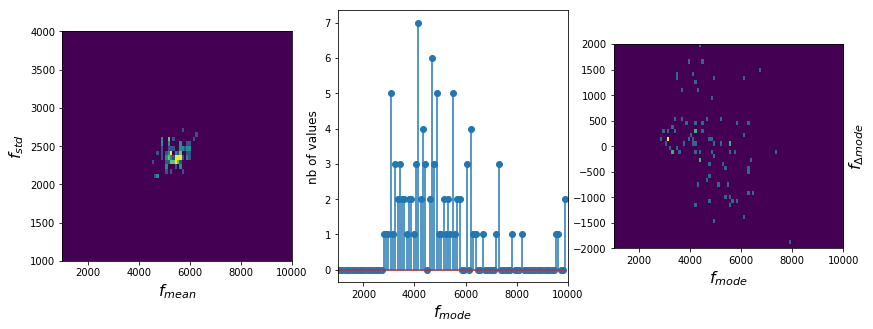

In [60]:
plot_features(1, sequence_spectogram_normalized, freqs_red)

<div class="alert alert-success">
By computing the mean of several sequences, it will provide a good - and standardized - visualization.
</div>

<div style="text-align: right"> <a href="#17" class="btn btn-success">Visualize the mean for each specy</a></div>

In [61]:
features1 = sequence_histogram1.flatten()
features2 = sequence_histogram2
features3 = sequence_histogram3.flatten()

### functions

In [62]:
def get_spectrogram(file, window_size=20, step_size=10):
    """
    This function open a wav file and return the desired normalized spectrogram
    inputs : 
        str file : name of the sound file (wav)
        int window_size : lenght of a frame in ms
        int step_size : for the overlapping
    output : 
        int category : category of the bird according to the name of the file
        array spectogram_normalized : the normalized spectrogram
        list freqs_red : list of frequences
    """
    
    record_id, _ = re.split('.wav',file)
    bird_category = data_sounds.loc[data_sounds['File ID']==int(record_id)]['English_name'].values[0]
    category = cat_bird.categories.tolist().index(bird_category)
    
    rate, frames = wavfile.read("Sounds/Out/" + file)
    n_frames = len(frames)
    
    # if stereo, keep only one channel
    if frames.ndim == 2:
        frames = frames[:,0]
    
    # Step 1 : select the most energetic frames
    # mean of the 1% most energetic frames 
    mean_high_NRJ_frames = np.mean(heapq.nlargest(n_frames//100, np.abs(frames)))
    # select only frames of that recording that have power of at least 0.25 of the estimated highest level
    frames = np.array([frame for i_frame, frame in enumerate(frames) if np.abs(frame) > 0.25 * mean_high_NRJ_frames])
    # update nb frames
    n_frames = len(frames)
    
    # Step 2 : split into 20ms chunks and get spectrogram
    window_size=20
    step_size=10
    freqs, times, spectrogram = log_specgram(frames, rate, window_size=window_size, step_size=step_size)
    
    # Step 3 : keep only 1-10KHz
    # keep only fq between 1kHz and 10 kHz
    indices = [i for i, fq in enumerate(freqs) if fq>1000 and fq<10000]   
    spectrogram_red = spectrogram[:,indices]
    freqs_red = freqs[indices]
    # Step 4: normalize
    spectogram_normalized = normalize(spectrogram_red, norm="l1", axis=1)
    
    return category, spectogram_normalized, freqs_red

In [63]:
def get_spectrogram_kasios(krecord_id, window_size=20, step_size=10):
    """
    This function open a wav file and return the desired normalized spectrogram
    inputs : 
        str file : name of the sound file (wav)
        int window_size : lenght of a frame in ms
        int step_size : for the overlapping
    output : 
        int category : category of the bird according to the name of the file
        array spectogram_normalized : the normalized spectrogram
        list freqs_red : list of frequences
    """

    rate, frames = wavfile.read("Sounds_Kasios/Out/" + str(krecord_id) + ".wav")
    n_frames = len(frames)
    
    # if stereo, keep only one channel
    if frames.ndim == 2:
        frames = frames[:,0]
    
    # Step 1 : select the most energetic frames
    # mean of the 1% most energetic frames 
    mean_high_NRJ_frames = np.mean(heapq.nlargest(n_frames//100, np.abs(frames)))
    # select only frames of that recording that have power of at least 0.25 of the estimated highest level
    frames = np.array([frame for i_frame, frame in enumerate(frames) if np.abs(frame) > 0.25 * mean_high_NRJ_frames])
    # update nb frames
    n_frames = len(frames)
    
    # Step 2 : split into 20ms chunks and get spectrogram
    window_size=20
    step_size=10
    freqs, times, spectrogram = log_specgram(frames, rate, window_size=window_size, step_size=step_size)
    
    # Step 3 : keep only 1-10KHz
    # keep only fq between 1kHz and 10 kHz
    indices = [i for i, fq in enumerate(freqs) if fq>1000 and fq<10000]   
    spectrogram_red = spectrogram[:,indices]
    freqs_red = freqs[indices]
    # Step 4: normalize
    spectogram_normalized = normalize(spectrogram_red, norm="l1", axis=1)
    
    return spectogram_normalized, freqs_red

In [64]:
def get_sequences(spectrogram, l_sequence=100, tolerance=0.3):
    """
    split the spectrogram in spectrograms of size l_sequence (default 100)
        and keep the last one if its lenght is longer than tolerance * l_sequence
            (overlap with the previous one)
    """
    nb_frames = len(spectrogram)
    list_sequences = []
    nb_sequences = nb_frames // l_sequence

    if nb_sequences != 0:
        for j in range(nb_sequences):
            list_sequences.append(spectrogram[j * l_sequence: (j+1) * l_sequence])
    else:
        # we have less than n_frames_per_sequence in the frame...
        # overlap the last sequence if there is sufficient information
        if (nb_frames % l_sequence > l_sequence * tolerance):
            list_sequences.append(spectrogram[-l_sequence:])

    return list_sequences

In [65]:
def get_sequences_per_category(all_spectrograms, lenght_sequence=100, tolerance=0.3):
    """
    This function transform a list of spectrograms
    ---------------------------------------------------------------------------
    inputs:
        all_spectrograms : list of spectrograms listed by category
        lenght_sequence : number of frame per sequence
        tolerance : keep only sequences 
                        with a lenght at least tolerance * lenght_sequence
    ---------------------------------------------------------------------------
    outputs:
        all_sequences : list of sequences listed by category
    """
    
    # concatene all spectrogram per category
    list_unique_spec = [[] for _ in range(nb_categories)]
    for category in range(nb_categories):
        if len(all_spectrograms[category])==0:
            continue
        list_unique_spec[category] = np.vstack(all_spectrograms[category])
    
    all_sequences = [get_sequences(list_unique_spec[category],
                                           l_sequence=lenght_sequence,
                                           tolerance=tolerance) 
                     for category in range(nb_categories)]

    return all_sequences

In [66]:
def edges(e_min, e_max, nb_bins):
    return np.arange(e_min, e_max + (e_max-e_min) / nb_bins, (e_max-e_min) / nb_bins)



In [67]:
def get_features(category, sequence, freq_red,
                 f_mean_edges = edges(1000, 10000, 100),
                 f_std_edges = edges(1000, 4000, 50),
                 f_mode_edges = edges(1000, 10000, 100),
                 f_delta_mode_edges = edges(-2000, 2000, 50),
                 n_frames_per_sequence=100):
    """
    """
    l_sequence = len(sequence)
    if l_sequence < 100:
        for i in range(l_sequence, 100):
            sequence.append(sequence[l_sequence-1])
            
    f_mean = [np.sum(freqs_red * sequence[i]) for i in range(n_frames_per_sequence)]
    f_std = [(np.abs(np.sum(sequence[i] * (freqs_red -f_mean[i]) **2 ))) ** (0.5) for i in range(n_frames_per_sequence)]
    f_mode = [freqs_red[np.argmax(sequence[i])] for i in range(n_frames_sequence)]
    f_delta_mode = np.roll(f_mode, -1) - f_mode

    sequence_histogram1, _, _ = np.histogram2d(f_mean, f_std, bins=(f_mean_edges, f_std_edges))
    features1 = sequence_histogram1.T.flatten()

    sequence_histogram2, _ = np.histogram(f_mode, bins=f_mode_edges)
    features2 = sequence_histogram2

    sequence_histogram3, _, _ = np.histogram2d(f_mode, f_delta_mode, bins=(f_mode_edges, f_delta_mode_edges))
    features3 = sequence_histogram3.T.flatten()
    
    return np.concatenate([[category], features1, features2, features3])

In [68]:
def get_features2(category, sequence, freq_red,
                  n_frames_per_sequence=100):
    """
    """
    l_sequence = len(sequence)
    if l_sequence < 100:
        for i in range(l_sequence, 100):
            sequence.append(sequence[l_sequence-1])
            
    f_mean = [np.sum(freqs_red * sequence[i]) for i in range(n_frames_per_sequence)]
    f_std = [(np.abs(np.sum(sequence[i] * (freqs_red -f_mean[i]) **2 ))) ** (0.5) for i in range(n_frames_per_sequence)]
    f_mode = [freqs_red[np.argmax(sequence[i])] for i in range(n_frames_sequence)]
    f_delta_mode = np.roll(f_mode, -1) - f_mode

    return np.concatenate([[category], f_mean, f_std, f_mode, f_delta_mode])

In [69]:
def plot2_features(title, H1, H2, H3, freq_red,
                   f_mean_edges = edges(1000, 10000, 100),
                   f_std_edges = edges(1000, 4000, 50),
                   f_mode_edges = edges(1000, 10000, 100),
                   f_delta_mode_edges = edges(-2000, 2000, 50),
                   n_frames_per_sequence=100):
    """
    """
    fig, axs = plt.subplots(1, 3, figsize=(14, 5))
    axs[0].imshow(H1.T,interpolation='nearest', origin='low', extent=[f_mean_edges[0], f_mean_edges[-1], f_std_edges[0], f_std_edges[-1]])
    axs[0].set_xlabel("$f_{mean}$", fontsize=16)
    axs[0].set_ylabel("$f_{std}$", fontsize=16)
    axs[0].set_xlim(f_mean_edges[0], f_mean_edges[-1])
    axs[0].set_ylim(f_std_edges[0], f_std_edges[-1])
    axs[0].set_aspect(3)

    axs[1].stem(f_mode_edges[:-1], H2)
    axs[1].set_xlabel("$f_{mode}$", fontsize=16)
    axs[1].set_ylabel("nb of values", fontsize=12)
    axs[1].set_xlim(f_mode_edges[0], f_mode_edges[-1])

    axs[2].imshow(H3.T, interpolation='nearest', origin='low', extent=[f_mode_edges[0], f_mode_edges[-1], f_delta_mode_edges[0], f_delta_mode_edges[-1]])
    axs[2].set_xlabel("$f_{mode}$", fontsize=16)
    axs[2].set_ylabel("$f_{\Delta mode}$", fontsize=16)
    axs[2].set_xlim(f_mode_edges[0], f_mode_edges[-1])
    axs[2].set_ylim(f_delta_mode_edges[0], f_delta_mode_edges[-1])
    axs[2].yaxis.set_label_position("right")
    axs[2].set_aspect(2)
     
    plt.suptitle(title, fontsize=24)
    plt.show()

## Scalability

### Create wav from mp3

Transform all mp3 from the In folder that correspond to a good record into wav to Out folder with a rate of 44100 Hz

In [70]:
f = IntProgress(min=0, max=len(data), description='Load files:', bar_style='success') # instantiate the bar
print("progress")
display(f) # display the bar
for file in os.listdir("Sounds/In/"):
    
    record_id = int(max(re.findall('\d+', file), key=len))
    # if the ID is in data_sounds, we apply 
    if record_id in data_sounds['File ID'].values:
        sound = AudioSegment.from_mp3("Sounds/In/"+file)
        sound = sound.set_frame_rate(44100)
        sound = sound.set_channels(1)
        sound.export("Sounds/Out/" + str(record_id) + ".wav", format="wav")
    f.value += 1
print("done !")

progress


IntProgress(value=0, bar_style='success', description='Load files:', max=2081)

done !


### Create features

In [71]:
from multiprocessing import Pool
import multiprocessing
from tqdm import tqdm_notebook as tqdm

In [72]:
cores = multiprocessing.cpu_count()
pool = Pool(processes=cores)
file_list = list(os.listdir("Sounds/Out/"))

all_spectrograms = [[] for _ in range(nb_categories)]

for category, spectrogram, freqs_red in tqdm(pool.imap_unordered(get_spectrogram, file_list), total=len(file_list)):
    all_spectrograms[category].append(spectrogram)

In [73]:
# retrieve sequences from spectrograms
all_sequences = get_sequences_per_category(all_spectrograms)

#### with histograms

In [74]:
# create the dataset from the sequences
dataset = pd.DataFrame(columns=range(10101))
n_rows = 0
for category in range(nb_categories):
    for j, sequence in enumerate(all_sequences[category]):
        dataset.loc[n_rows] = get_features(category, sequence, freqs_red)
        n_rows += 1

In [75]:
dataset.head()

0      1      2      3      4      5      6      7      8      9      \
0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
4    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

   ...    10091  10092  10093  10094  10095  10096  10097  10098  10099  10100  
0  ...      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
1  ...      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
2  ...      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
3  ...      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
4  ...      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  

[5 rows x 10101 columns]

In [76]:
# create the dataset
dataset.to_csv("dataset.csv", float_format='%.3f')

In [77]:
dataset2 = dataset.copy()

In [78]:
dataset2 = dataset2.astype(int)

In [79]:
dataset2.to_csv("dataset2.csv")

In [80]:
len(dataset)

8398

#### simple features

In [81]:
# a dataset with only f_mean, f_std, f_mode and f_delta_mode.

In [82]:
# create the dataset from the sequences
dataset_red = pd.DataFrame(columns=range(401))
n_rows = 0
for category in range(nb_categories):
    for j, sequence in enumerate(all_sequences[category]):
        dataset_red.loc[n_rows] = get_features2(category, sequence, freqs_red)
        n_rows += 1

In [83]:
# create the dataset
dataset_red.to_csv("dataset_red.csv", float_format='%.3f')

## Compare differents species

Using the mean of each feature by specy...

In [85]:
dataset_category = dataset2.groupby(0).mean()

In [86]:
dataset_category.insert(0, '0', 0.0)

In [87]:
categories  = []
features1 = []
features2 = []
features3 = []
for row in dataset_category.iterrows():
    index, data = row
    categories.append(index)
    features1.append(np.reshape(data.values[0:5000], (50, 100)).T)
    features2.append(data.values[5000:5100])
    features3.append(np.reshape(data.values[5100:10100], (50, 100)).T)
freqs = np.array(range(1050, 10000, 50))

### Plot the features

<a id='17'></a>

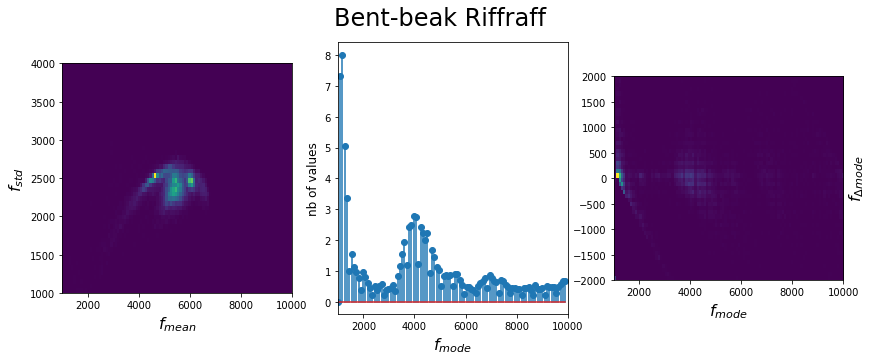

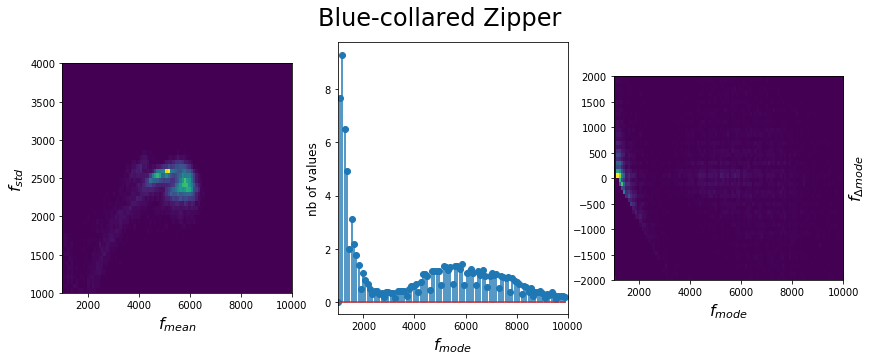

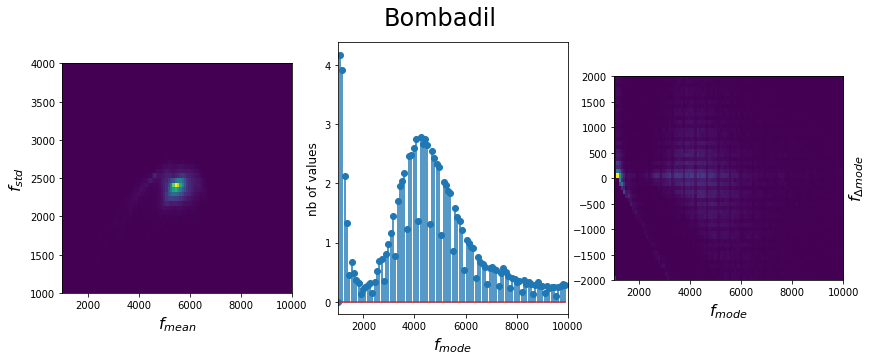

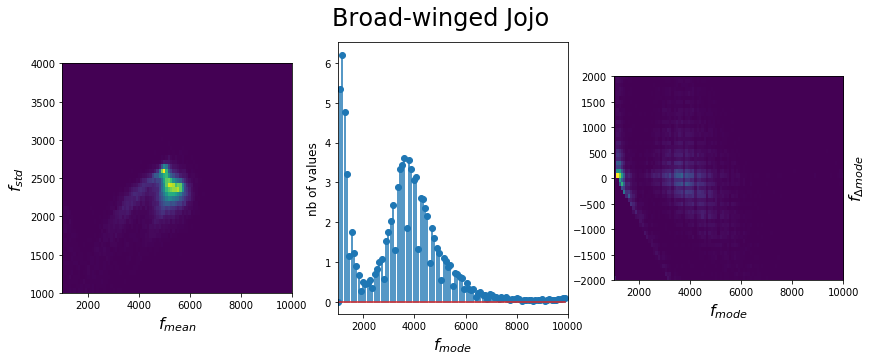

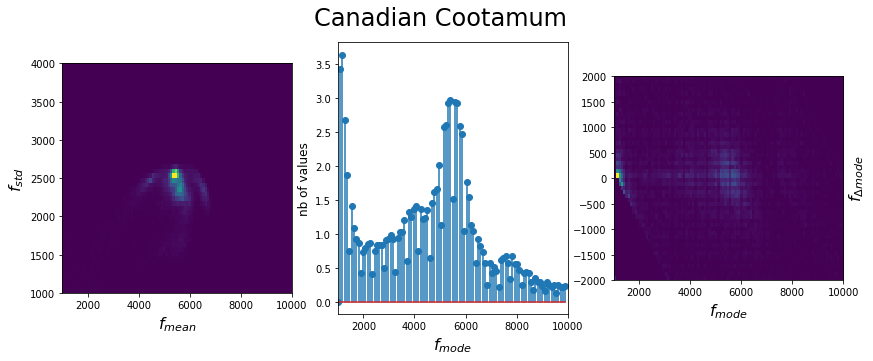

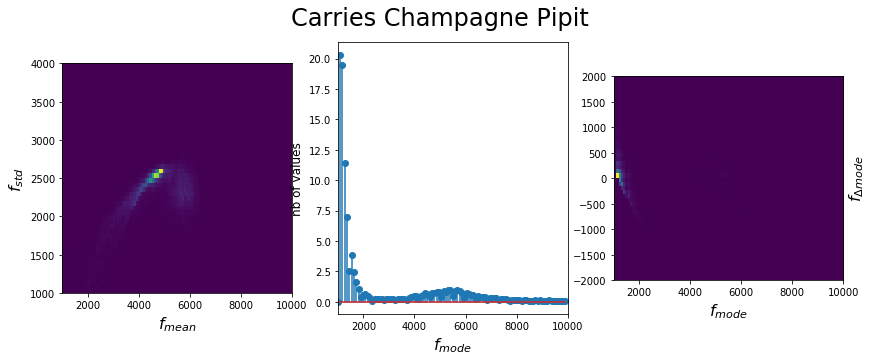

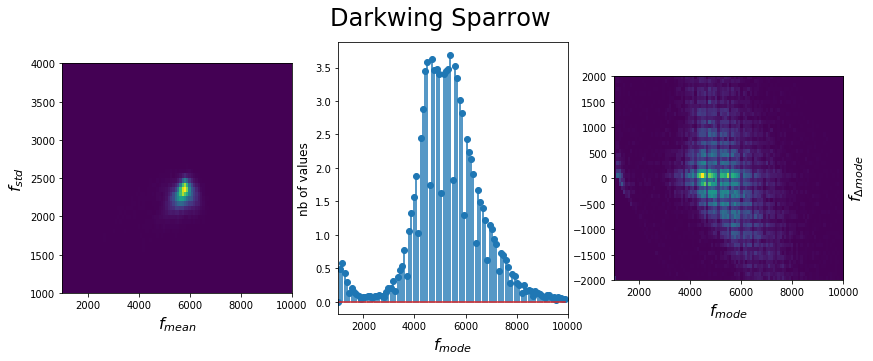

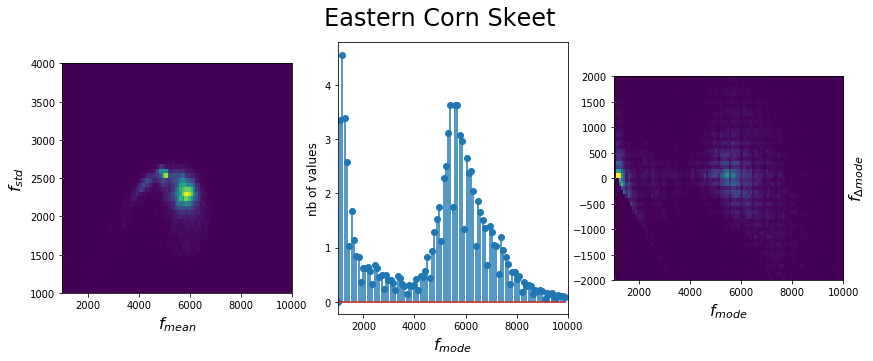

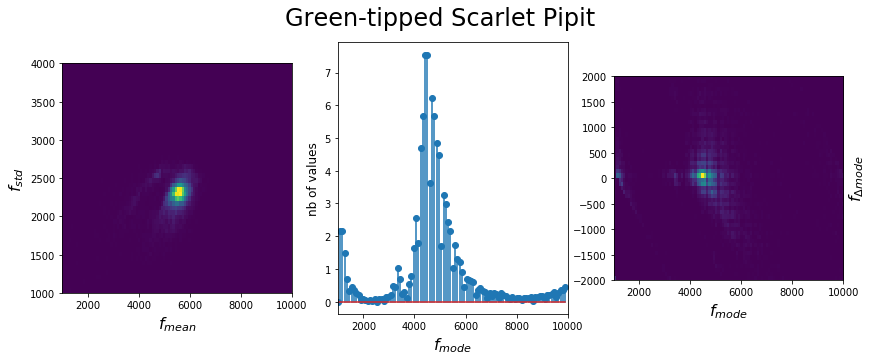

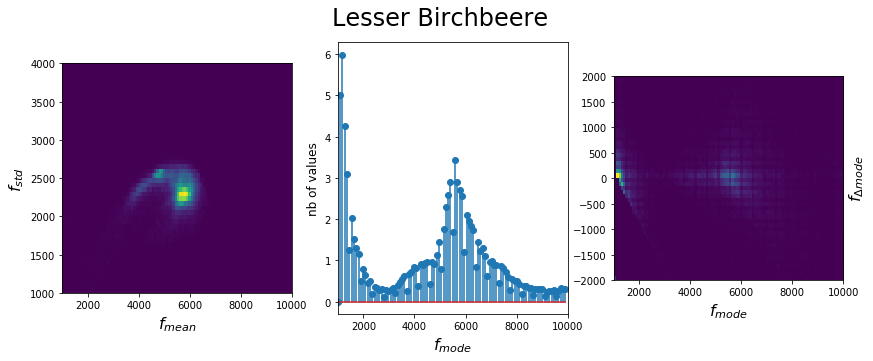

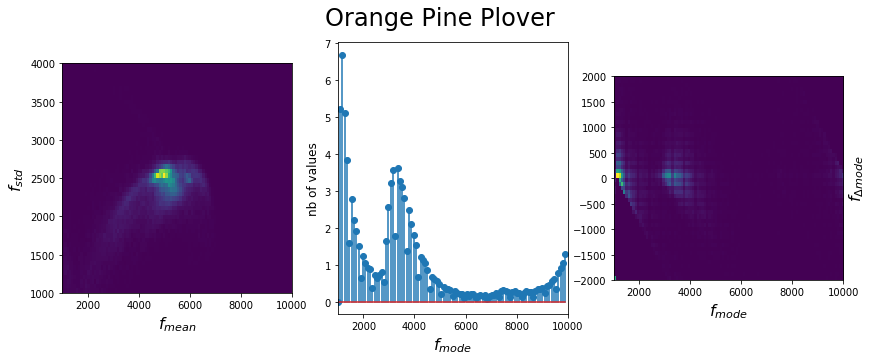

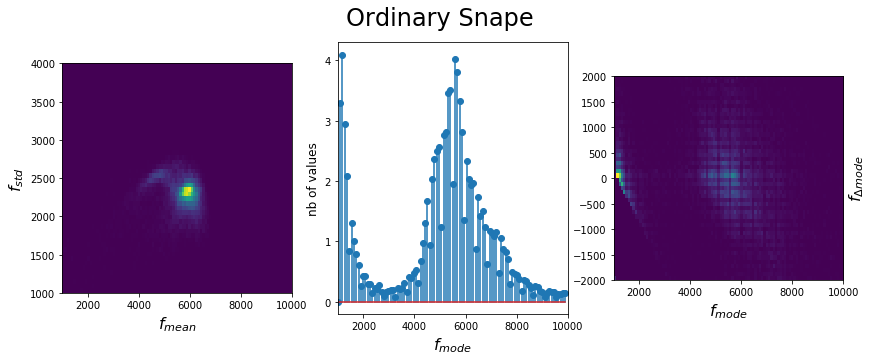

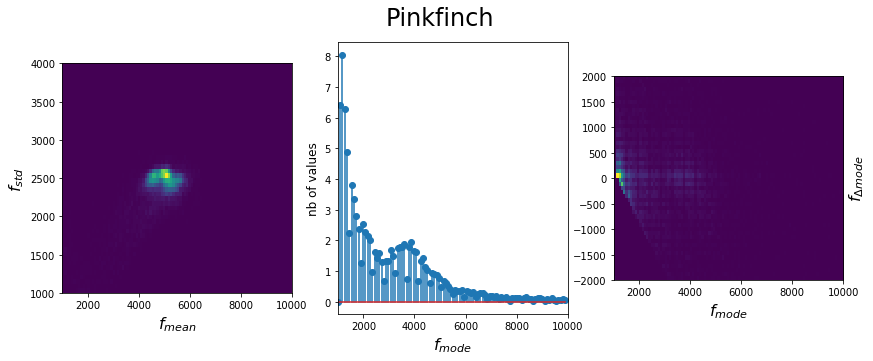

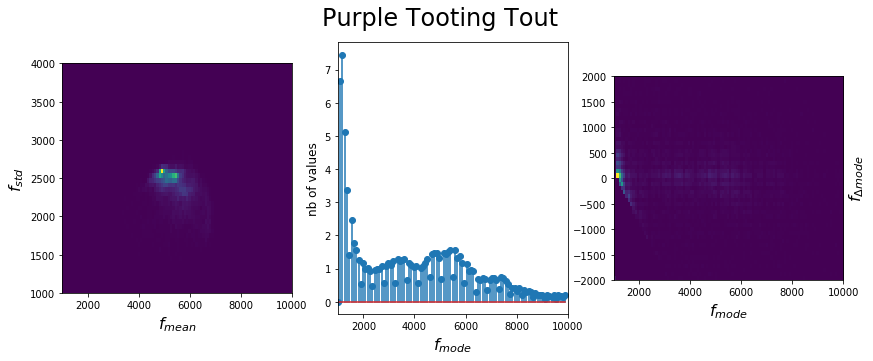

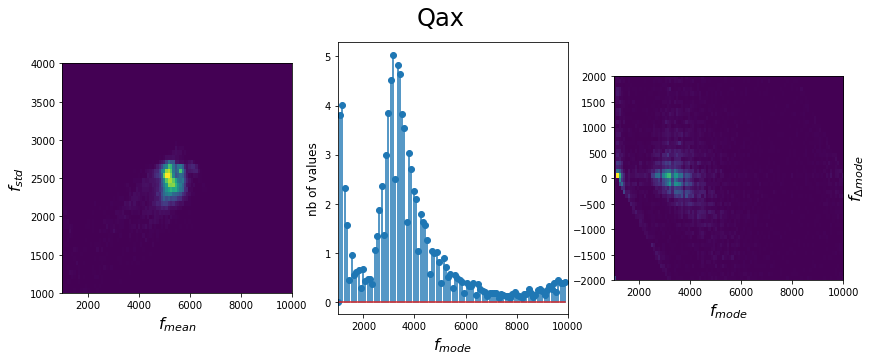

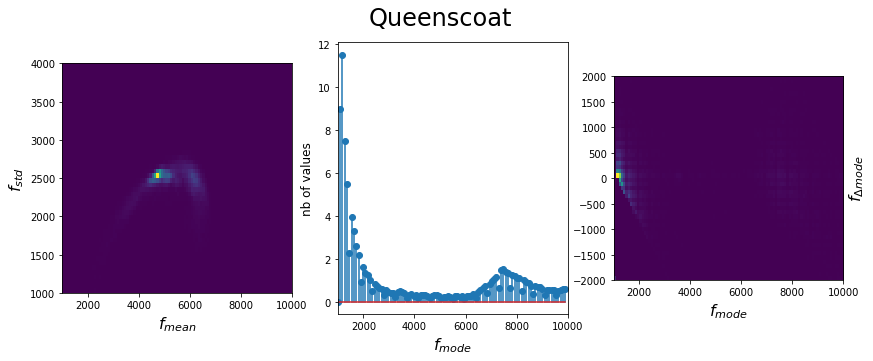

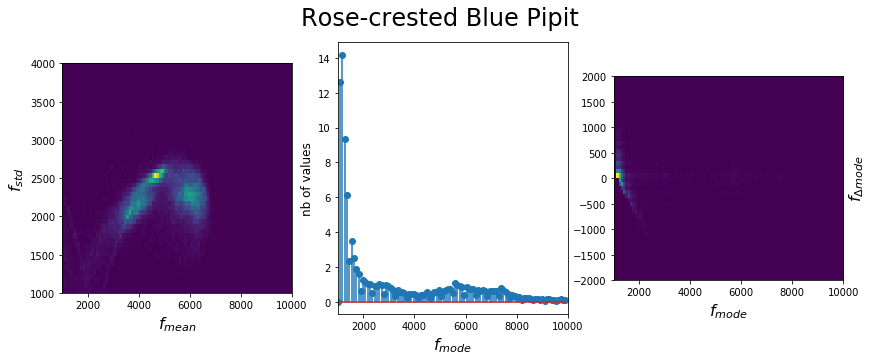

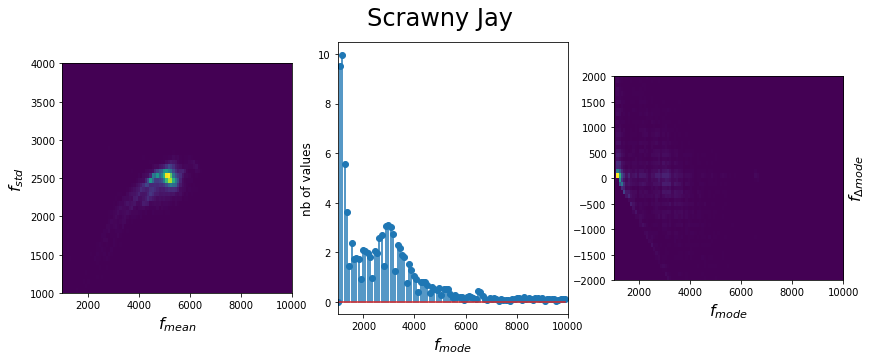

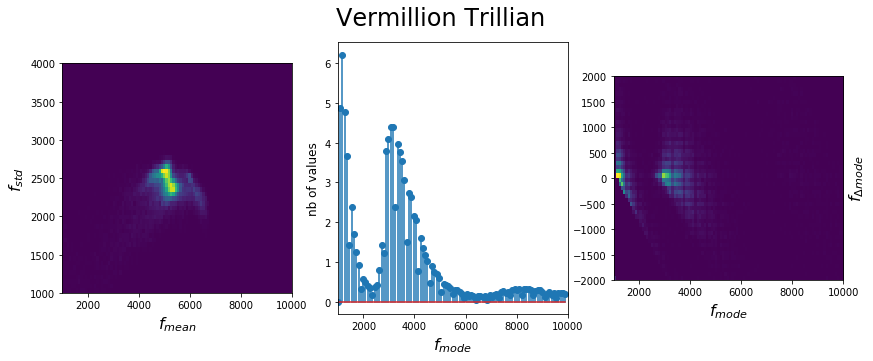

In [88]:
for i, H1, H2, H3 in zip(categories, features1, features2, features3):
    plot2_features(cat_bird.categories.tolist()[i], H1, H2, H3, freqs)

<div class="alert alert-success">
The three histograms are usefull to discriminate birds.
</div>

<div style="text-align: right"> <a href="#18" class="btn btn-success">Test a similarity measure</a></div>

### Similarity

In [89]:
from skimage.measure import compare_ssim

In [90]:
ssim_beetween = np.array([[np.mean([compare_ssim(features1[i], features1[j], full=True)[0], 
                                    compare_ssim(features2[i], features2[j], full=True)[0],
                                    compare_ssim(features3[i], features3[j], full=True)[0]])
                           for i in range(nb_categories)] 
                          for j in range(nb_categories)])

/home/hhours/anaconda3/lib/python3.6/site-packages/skimage/util/arraycrop.py:177: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = ar[slices]


In [91]:
#sim2 = np.array([[np.mean([np.linalg.norm(features1[i]-features1[j], ord='nuc'), 
#                           np.linalg.norm(features2[i]-features2[j]), 
#                           np.linalg.norm(features3[i]-features3[j], ord='nuc')]) 
#                           for i in range(nb_categories)] 
#                          for j in range(nb_categories)])

In [92]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [93]:
def plot_heatmap(data, row_labels, col_labels, title="",
                    cbar_kw={}, cbarlabel="", **kwargs):
    """
    Plot a heatmap from a numpy array and two lists of labels.

    Arguments:
        data       : A 2D numpy array of shape (N,M)
        row_labels : A list or array of length N with the labels
                     for the rows
        col_labels : A list or array of length M with the labels
                     for the columns
    Optional arguments:
        ax         : A matplotlib.axes.Axes instance to which the heatmap
                     is plotted. If not provided, use current axes or
                     create a new one.
        cbar_kw    : A dictionary with arguments to
                     :meth:`matplotlib.Figure.colorbar`.
        cbarlabel  : The label for the colorbar
    All other arguments are directly passed on to the imshow call.
    """
    fig, ax = plt.subplots(figsize=(10,10))
    
    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    
    cbar = ax.figure.colorbar(im, cax=cax, **cbar_kw)
    
    
    
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    #ax.tick_params(top=True, bottom=False,
    #               labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)
    ax.set_title(title, fontsize=30)
    fig.tight_layout()
    plt.show()

<a id='18'></a>

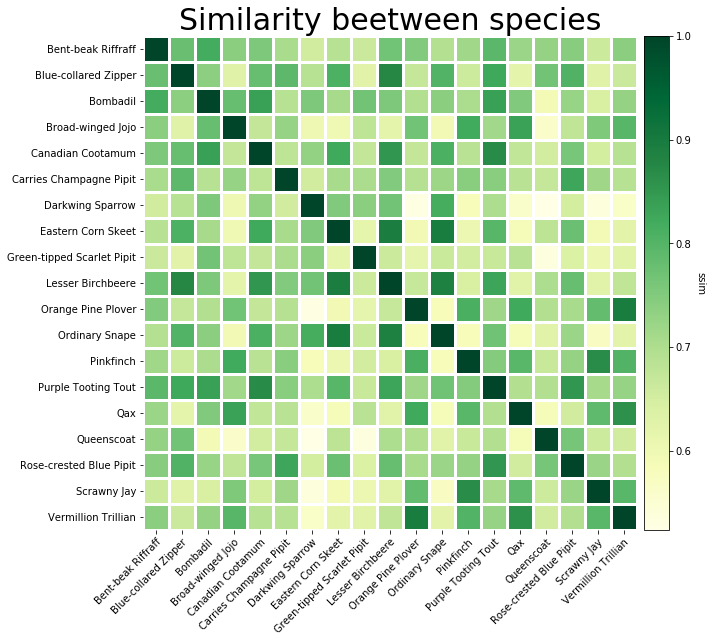

In [94]:
plot_heatmap(ssim_beetween, cat_bird.categories.tolist(), cat_bird.categories.tolist(), "Similarity beetween species", cmap="YlGn", cbarlabel="ssim")

<div class="alert alert-success">
Comment?
</div>

<div style="text-align: right"> <a href="#19" class="btn btn-success">ML Classification</a></div>

## Kasios records

In [95]:
f = IntProgress(min=0, max=15, description='Load files:', bar_style='success') # instantiate the bar
display(f) # display the bar
for file in os.listdir("Sounds_Kasios/In/"):
    
    record_id = int(max(re.findall('\d+', file), key=len))
    # if the ID is in data_sounds, we apply 
    sound = AudioSegment.from_mp3("Sounds_Kasios/In/"+file)
    sound = sound.set_frame_rate(44100)
    sound = sound.set_channels(1)
    sound.export("Sounds_Kasios/Out/" + str(record_id) + ".wav", format="wav")
    f.value += 1
nb_kasios = f.value

IntProgress(value=0, bar_style='success', description='Load files:', max=15)

In [96]:
list_kasios_sequences = [[] for i in range(nb_kasios)]
for i in range(nb_kasios):
    t_spectogram_normalized, t_freqs_red = get_spectrogram_kasios(i+1)
    list_kasios_sequences[i].extend(get_sequences(t_spectogram_normalized))

In [97]:
# create the dataset from the sequences
dataset_kasios = pd.DataFrame(columns=range(10101))
n_rows = 0
for id in range(nb_kasios):
    for _, sequence in enumerate(list_kasios_sequences[id]):
        dataset_kasios.loc[n_rows] = get_features(id, sequence, t_freqs_red)
        n_rows += 1

In [98]:
# create the dataset_red from the sequences
dataset_kasios_red = pd.DataFrame(columns=range(401))
n_rows = 0
for id in range(nb_kasios):
    for _, sequence in enumerate(list_kasios_sequences[id]):
        dataset_kasios_red.loc[n_rows] = get_features2(id, sequence, t_freqs_red)
        n_rows += 1

In [99]:
dataset_kasios_red.to_csv("dataset_kasios_red.csv", float_format='%.3f')

In [100]:
nb_sequence_per_kasios = dataset_kasios_red[0].value_counts()

In [101]:
kasios_mean = dataset_kasios.groupby(0).mean()

In [102]:
kasios_mean.insert(0, '0', 0.0)

In [103]:
l_kasios_id  = []
features1k = []
features2k = []
features3k = []
for row in kasios_mean.iterrows():
    index, data = row
    l_kasios_id.append(index)
    features1k.append(np.reshape(data.values[0:5000], (50, 100)).T)
    features2k.append(data.values[5000:5100])
    features3k.append(np.reshape(data.values[5100:10100], (50, 100)).T)
freqs = np.array(range(1050, 10000, 50))

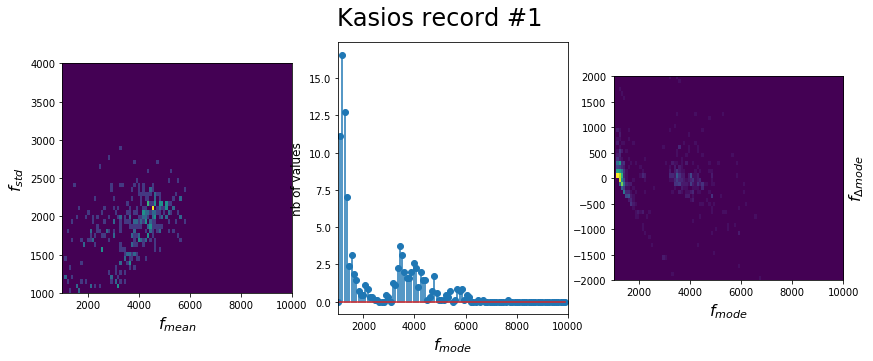

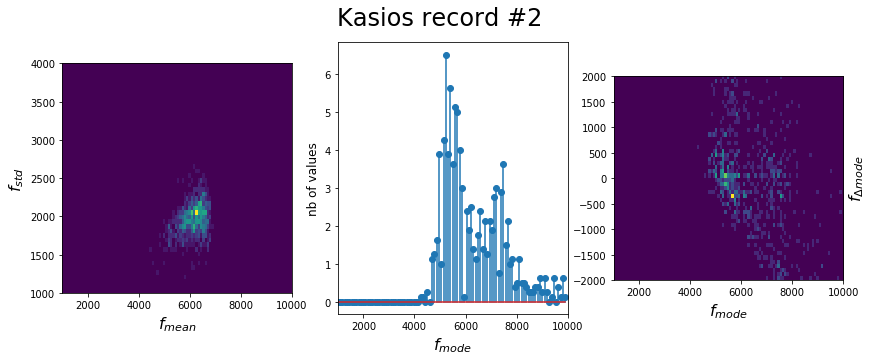

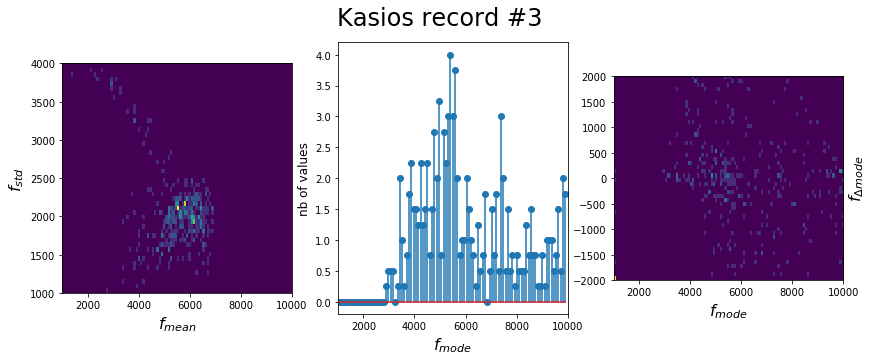

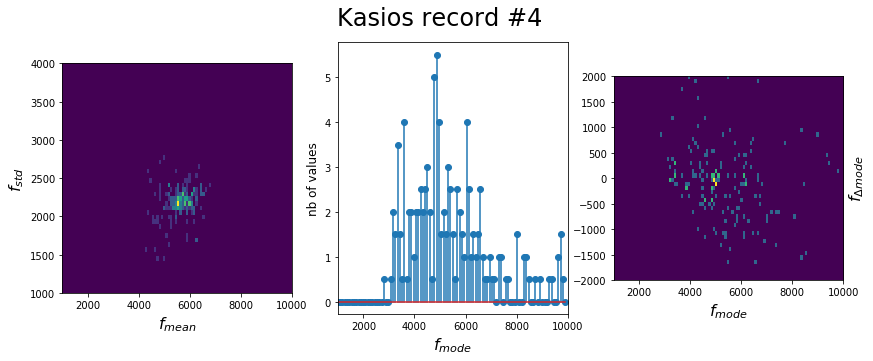

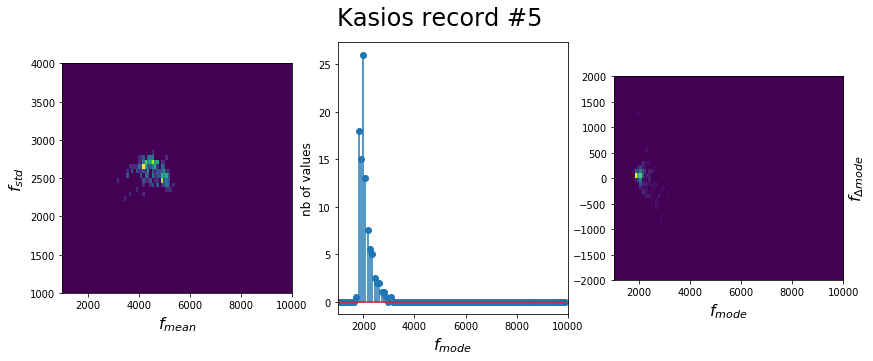

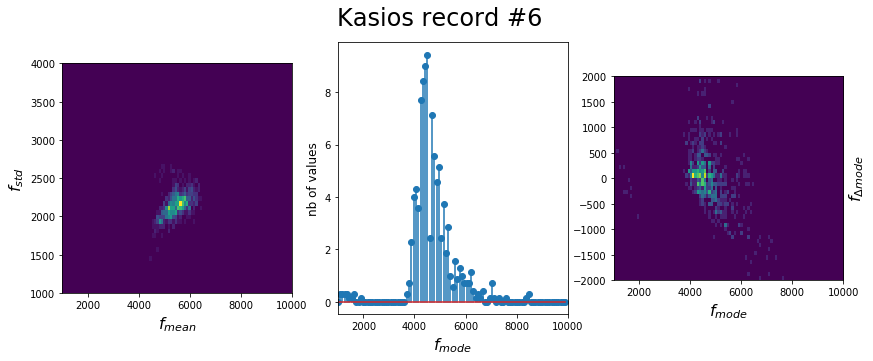

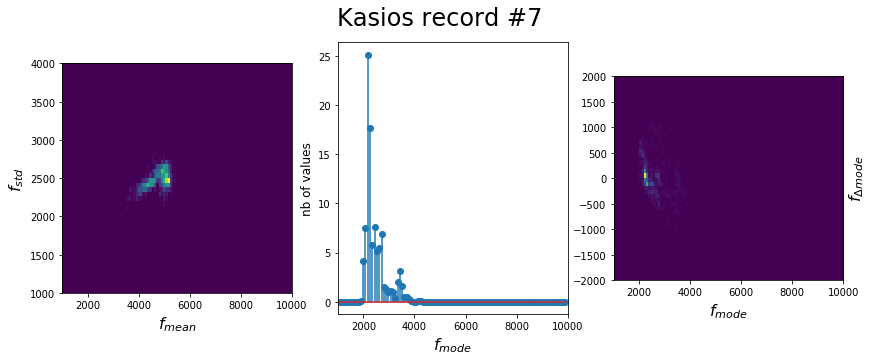

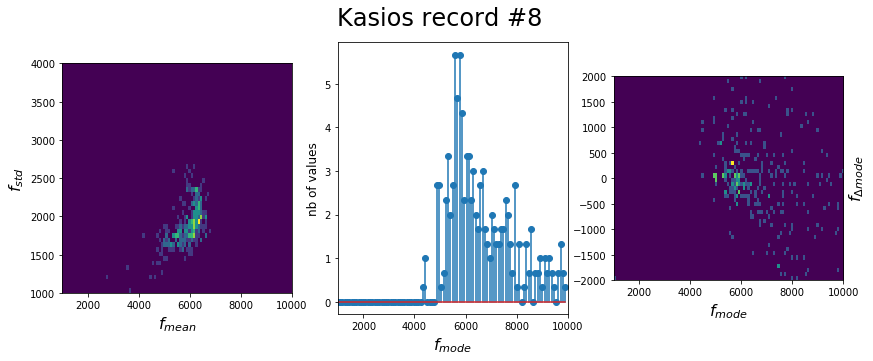

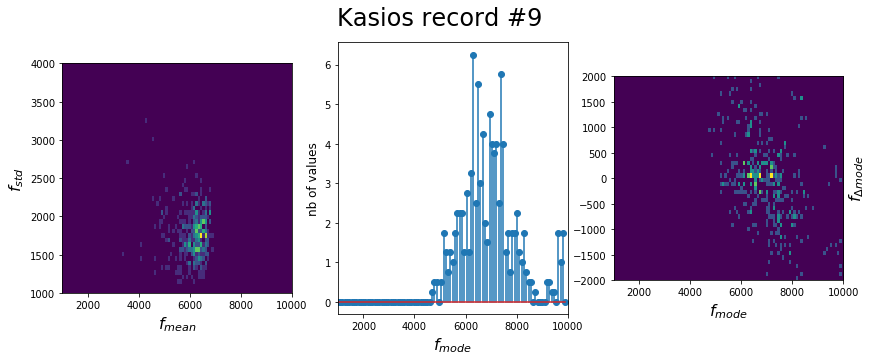

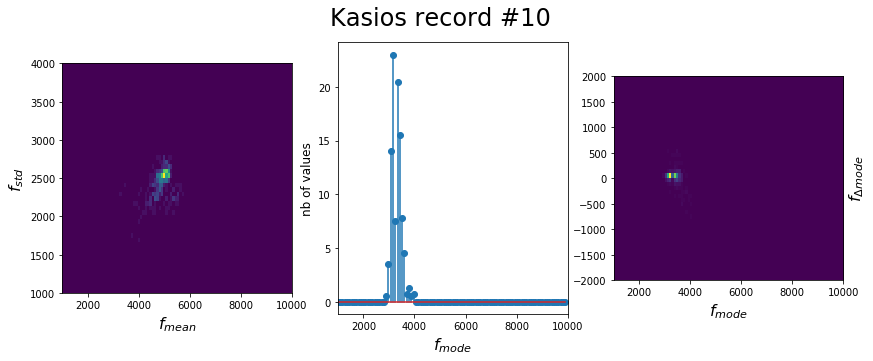

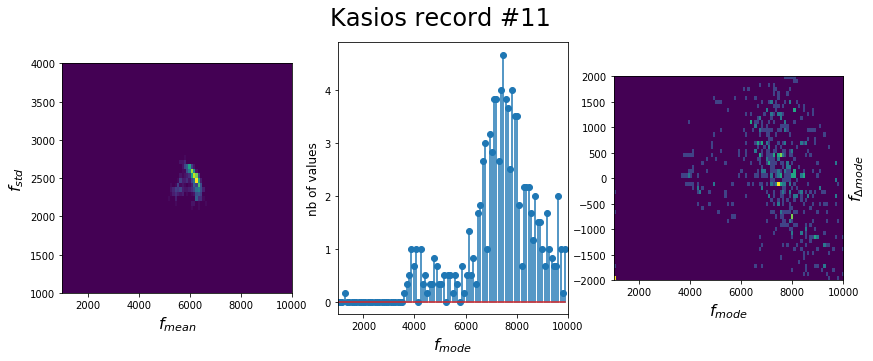

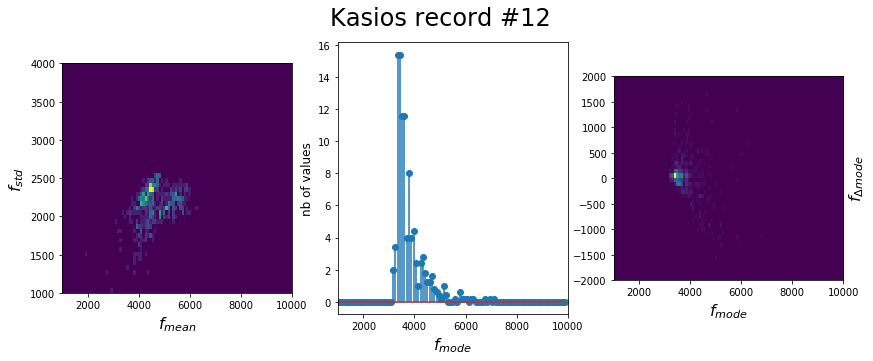

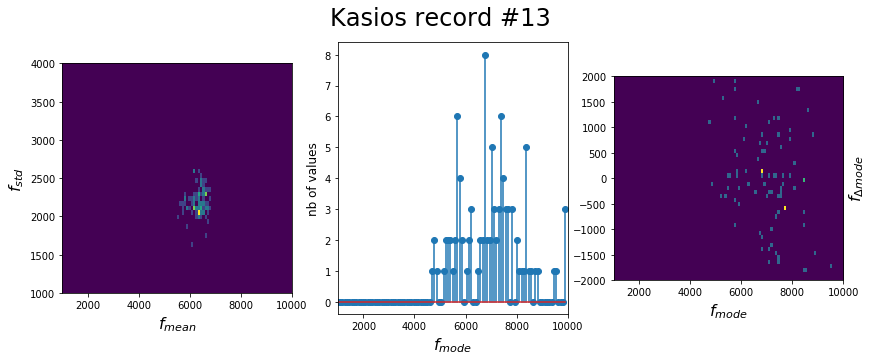

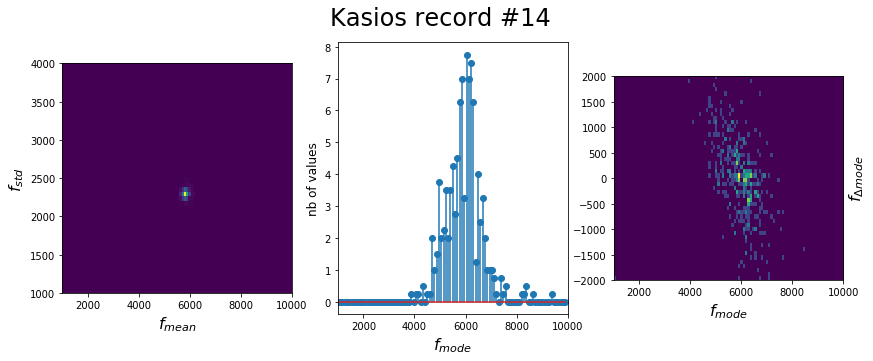

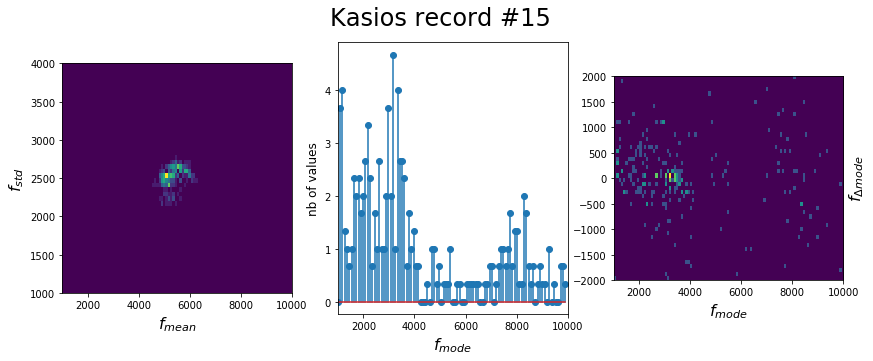

In [104]:
for i, H1, H2, H3 in zip(l_kasios_id, features1k, features2k, features3k):
    plot2_features("Kasios record #" + str(int(i+1)), H1, H2, H3, freqs)

In [105]:
kasios_label = ["Kasios record #" + str(int(i+1)) for i in range(nb_kasios)]

In [106]:
ssim_k = np.array([[np.mean([compare_ssim(features1[i], features1k[j], full=True)[0], 
                             compare_ssim(features2[i], features2k[j], full=True)[0],
                             compare_ssim(features3[i], features3k[j], full=True)[0]])
                           for i in range(nb_categories)] 
                          for j in range(nb_kasios)])

/home/hhours/anaconda3/lib/python3.6/site-packages/skimage/util/arraycrop.py:177: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = ar[slices]


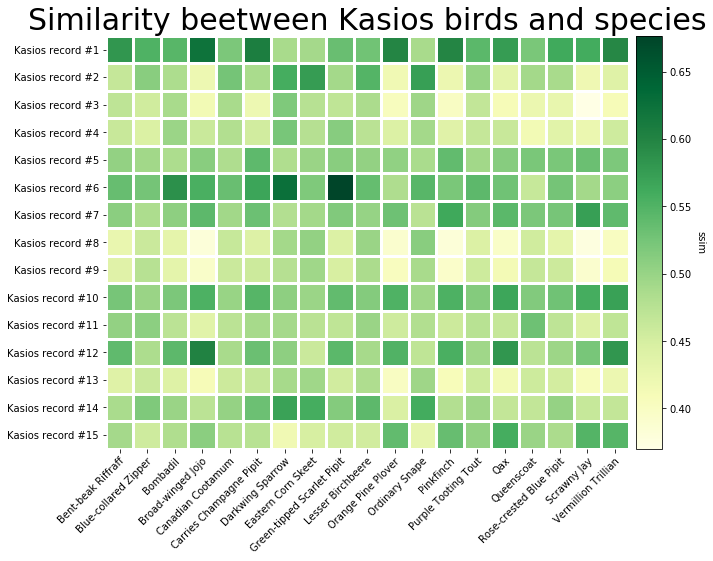

In [107]:
plot_heatmap(ssim_k, kasios_label, cat_bird.categories.tolist(), 
                "Similarity beetween Kasios birds and species", 
                cmap="YlGn", cbarlabel="ssim")

# Classification

In [108]:
from sklearn.neighbors import KNeighborsClassifier

In [109]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

In [110]:
# dataset with all 10100 fatures
dataset3 = dataset.copy()
y = dataset3[0]
X = dataset3.drop(dataset3.columns[0], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [111]:
scaler1 = StandardScaler()
scaler1.fit(X_train)
X_train = scaler1.transform(X_train)
X_test = scaler1.transform(X_test)

In [112]:
# dataset with 400 features
dataset3_red = dataset_red.copy()
y_red = dataset3_red[0]
X_red = dataset3_red.drop(dataset3_red.columns[0], axis=1)
X_red_train, X_red_test, y_red_train, y_red_test = train_test_split(X_red, y_red, test_size=0.3, random_state=0)

In [113]:
scaler2 = StandardScaler()
scaler2.fit(X_red_train)
X_red_train = scaler2.transform(X_red_train)
X_red_test = scaler2.transform(X_red_test)

In [114]:
kasios_id = dataset_kasios[0]
X_kasios = dataset_kasios.drop(dataset_kasios.columns[0], axis=1)
X_kasios = scaler1.transform(X_kasios)

In [115]:
X_kasios_red = dataset_kasios_red.drop(dataset_kasios_red.columns[0], axis=1)
X_kasios_red = scaler2.transform(X_kasios_red)

## Multi-class Classification

### With histogram features (10100 features)

In [116]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier

<a id='19'></a>

In [117]:
random_forest = OneVsRestClassifier(RandomForestClassifier(n_estimators=100, random_state=1))
random_forest.fit(X_train, y_train)

OneVsRestClassifier(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False),
          n_jobs=None)

In [118]:
random_forest.score(X_test, y_test)

0.5107142857142857

<div class="alert alert-success">
0.5 in multiclass corresponds to 0.964 for each of the 19 species... 
</div>

In [119]:
probas = random_forest.predict_proba(X_kasios)

In [120]:
i = 0
probas_kasios = []
for j in range(nb_kasios):
    probas_kasios.append(np.mean(np.array([probas[i+k] for k in range(kasios_id.value_counts()[j])]), axis=0))
    i+=kasios_id.value_counts()[j]
probas_kasios = np.array(probas_kasios)

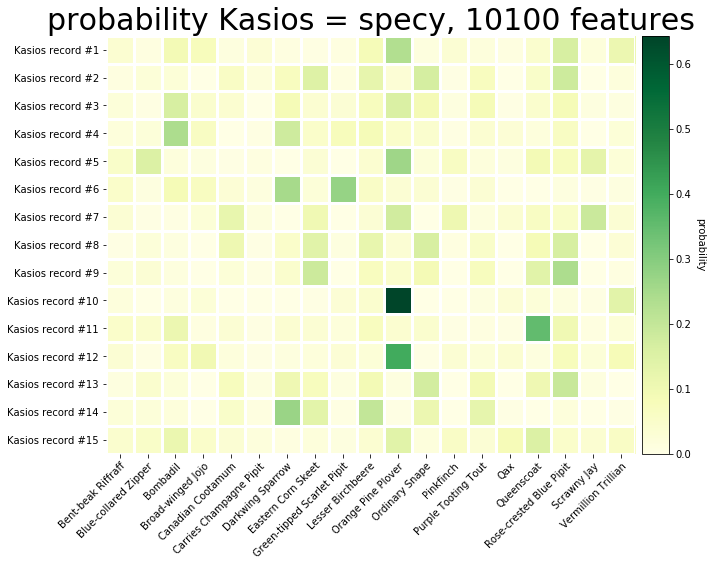

In [121]:
plot_heatmap(probas_kasios,kasios_label, cat_bird.categories.tolist(), "probability Kasios = specy, 10100 features", cmap="YlGn", cbarlabel="probability")

In [156]:
print("--------------3 MOST PROBABLE SPECIES BY KASIOS RECORD------------------------")
print("******************************************************************************")
for j in range(nb_kasios):
    bestprobas = heapq.nlargest(3, zip(probas_kasios[j,:], cat_bird.categories.tolist()))
    print("Kasios record #", j+1, " : ")
    for i, bestproba in enumerate(bestprobas):
        print("      {} : {} , proba {}".format(i+1, bestproba[1], bestproba[0]))

--------------3 MOST PROBABLE SPECIES BY KASIOS RECORD------------------------
******************************************************************************
Kasios record # 1  : 
      1 : Orange Pine Plover , proba 0.2325603567771147
      2 : Rose-crested Blue Pipit , proba 0.16442669980066366
      3 : Vermillion Trillian , proba 0.10882016278833276
Kasios record # 2  : 
      1 : Rose-crested Blue Pipit , proba 0.1828847858081056
      2 : Ordinary Snape , proba 0.16586969109055938
      3 : Eastern Corn Skeet , proba 0.14791976605304016
Kasios record # 3  : 
      1 : Bombadil , proba 0.16420298016867563
      2 : Orange Pine Plover , proba 0.15570455155746507
      3 : Ordinary Snape , proba 0.09036977364045032
Kasios record # 4  : 
      1 : Bombadil , proba 0.2408088235294117
      2 : Darkwing Sparrow , proba 0.1798713235294117
      3 : Lesser Birchbeere , proba 0.0842830882352941
Kasios record # 5  : 
      1 : Orange Pine Plover , proba 0.2610922436459246
      2 : Blue-co

<div class="alert alert-success">
We need at least the three first results.
Conclusions will be done later (next assignement?).
</div>

In [122]:
from scipy.stats import mode

In [123]:
predict = random_forest.predict(X_kasios)

i = 0
predict_kasios = []
for j in range(nb_kasios):
    predict_kasios.append(mode(np.array([predict[i+k] for k in range(kasios_id.value_counts()[j])]), axis=None))
    i+=kasios_id.value_counts()[j]
predict_kasios = np.array(predict_kasios).T[0][0].astype(int)

In [125]:
def plot_comparaison_predict(prediction):
    for i, H1, H2, H3 in zip(l_kasios_id, features1k, features2k, features3k):
        print("==============================================================================================================")
        plot2_features(cat_bird.categories.tolist()[i_bp], features1[i_bp], features2[i_bp], features3[i_bp], freqs)    
        plot2_features("Kasios record #" + str(int(i + 1)), H1, H2, H3, freqs)
        plot2_features("predicted : " + cat_bird.categories.tolist()[prediction[int(i)]], features1[prediction[int(i)]], features2[prediction[int(i)]], features3[prediction[int(i)]], freqs)

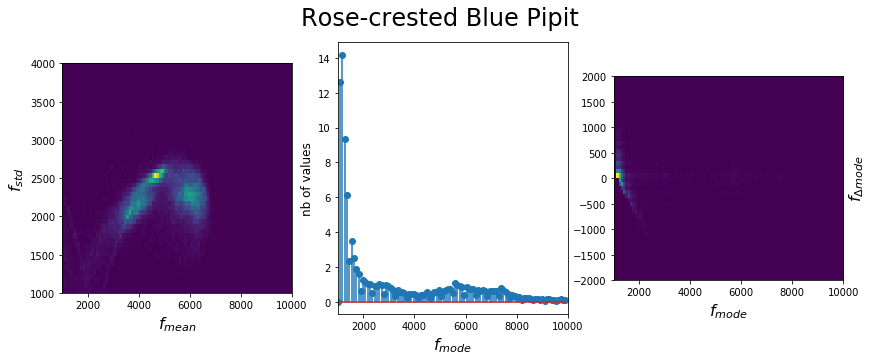

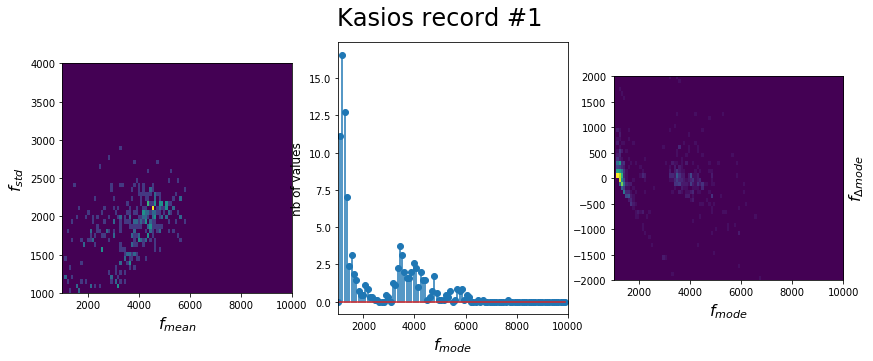

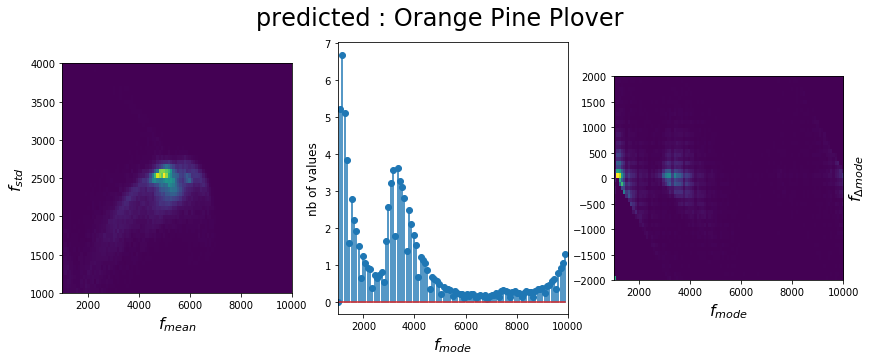

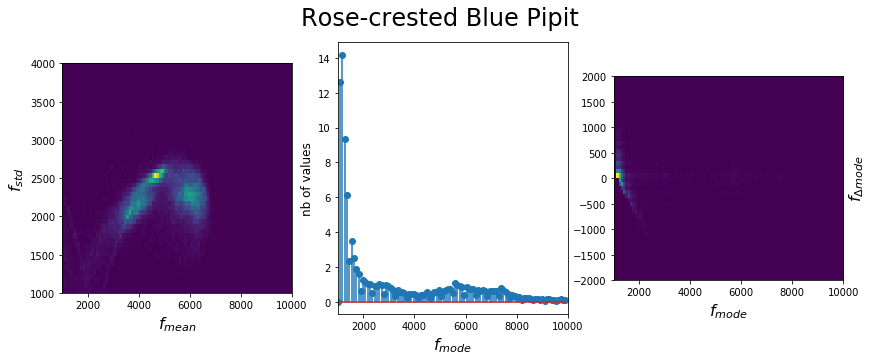

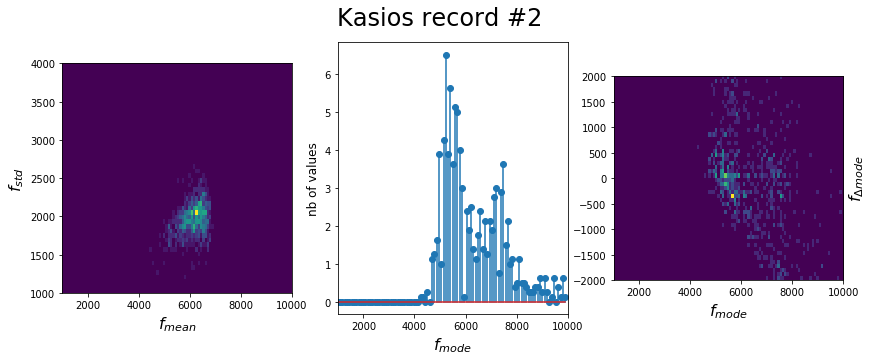

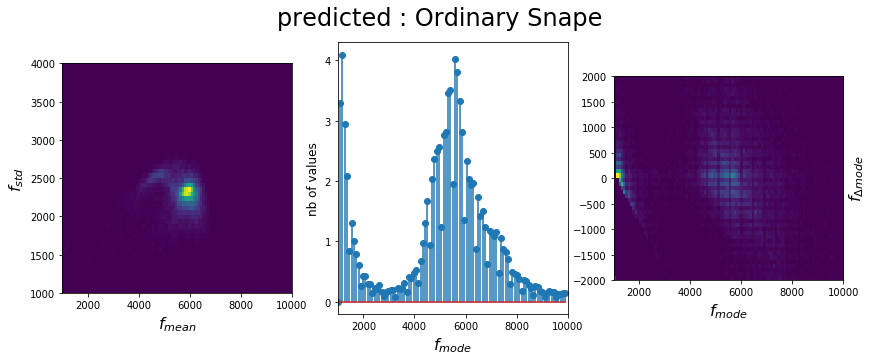

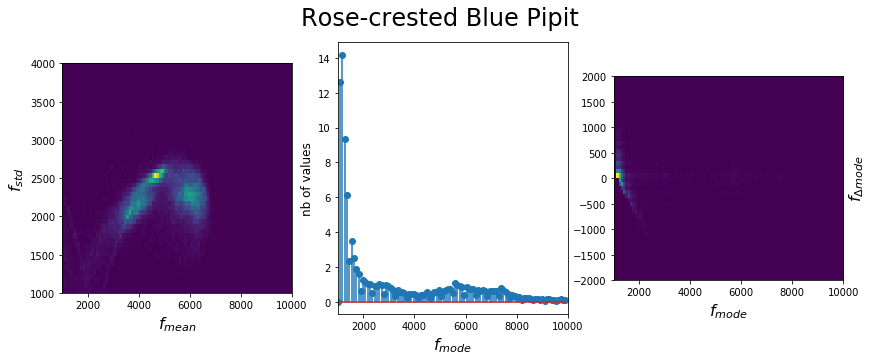

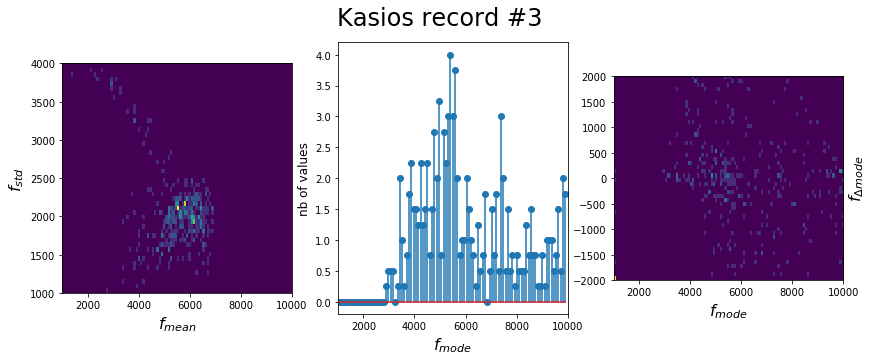

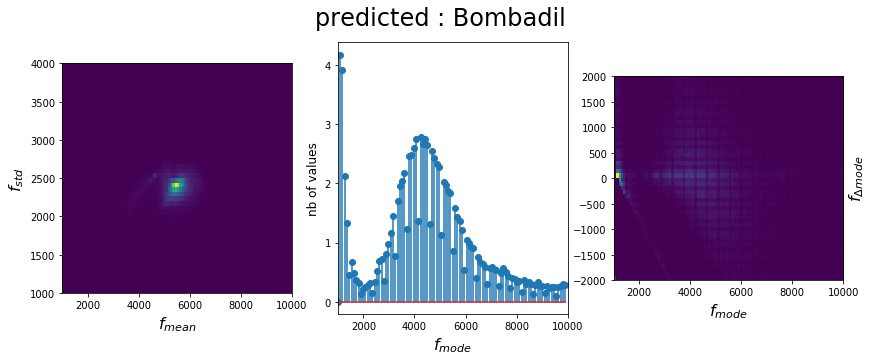

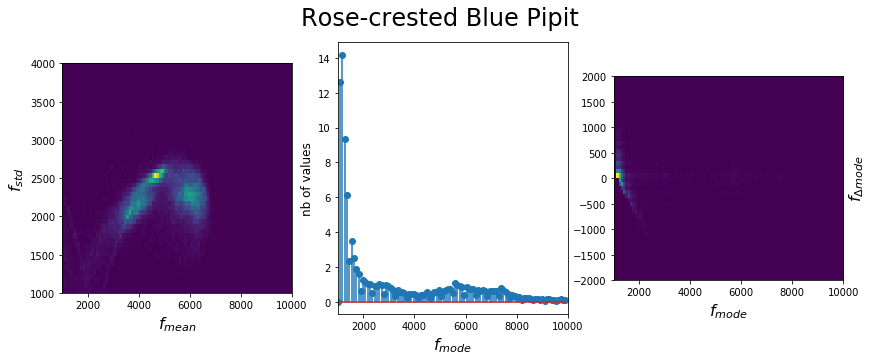

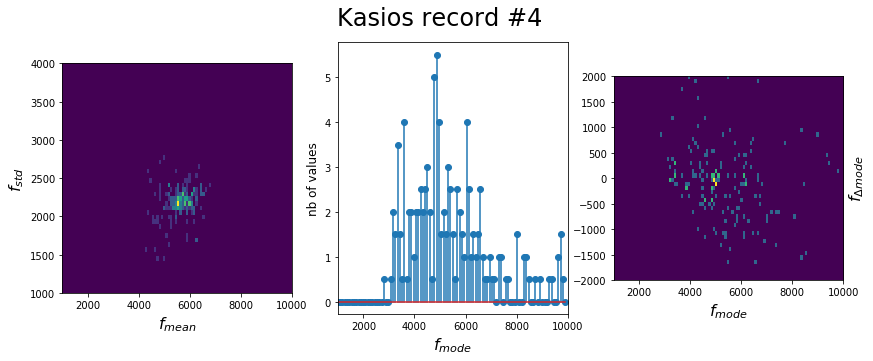

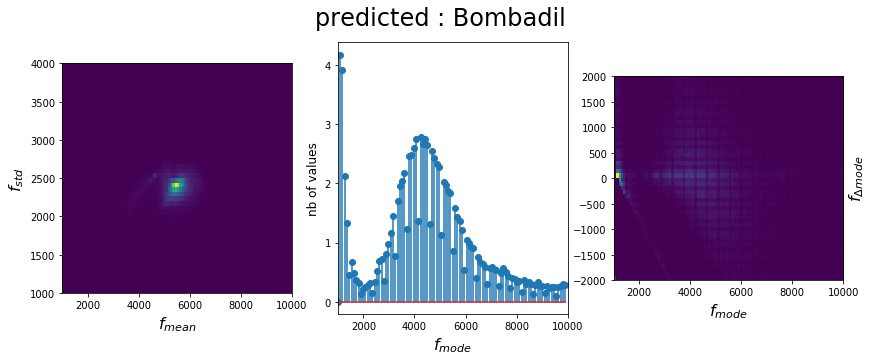

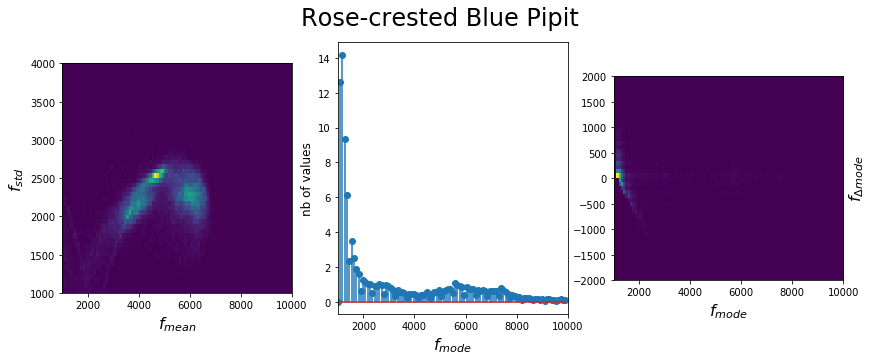

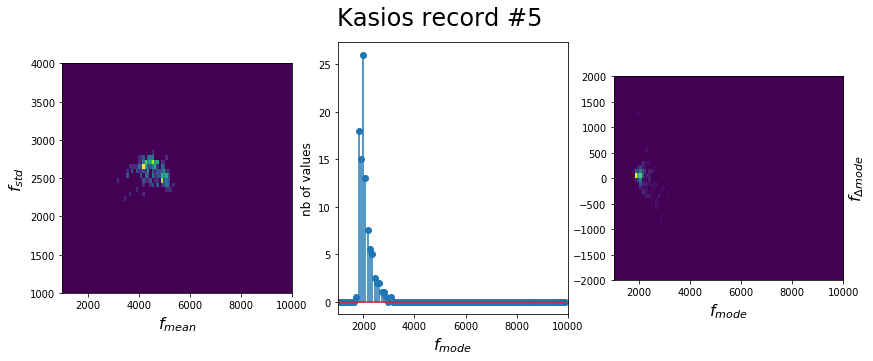

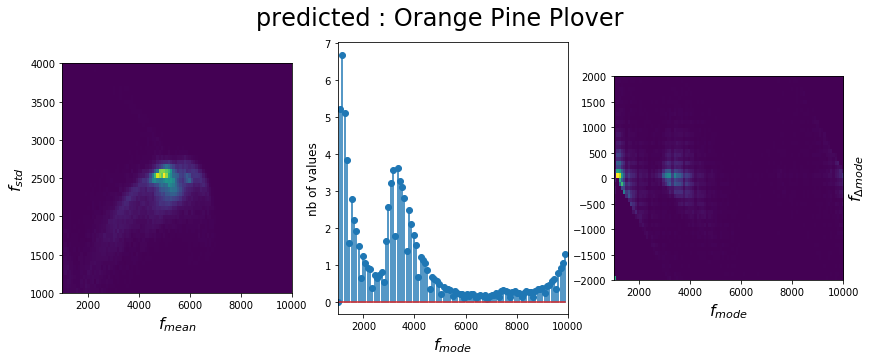

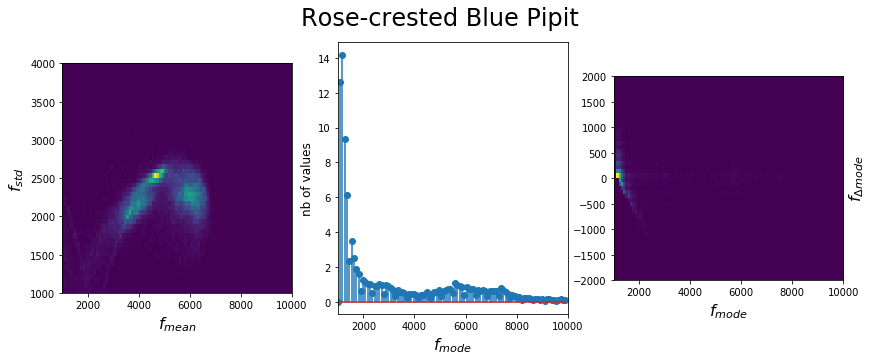

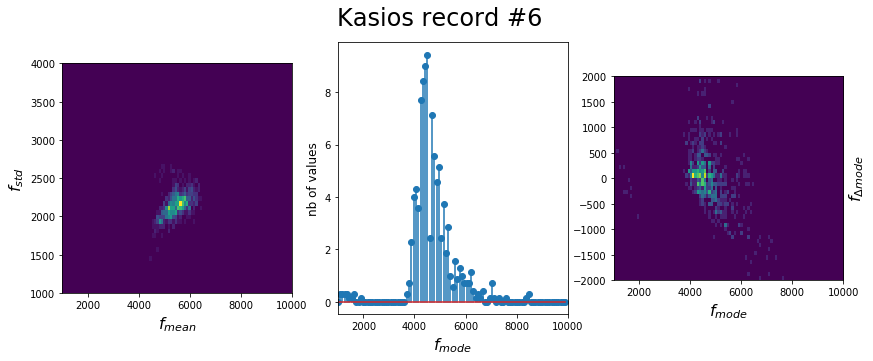

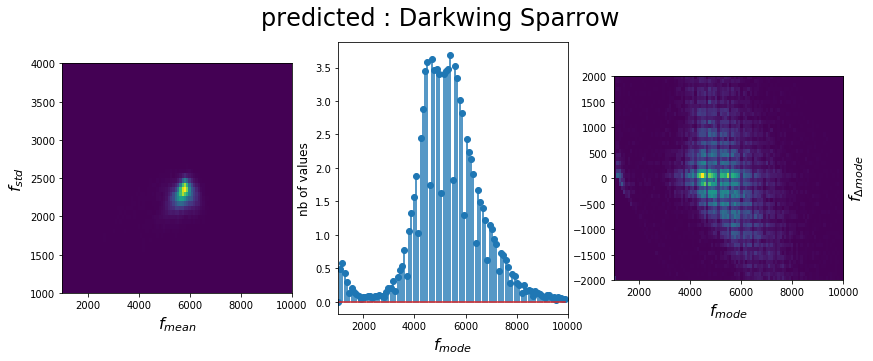

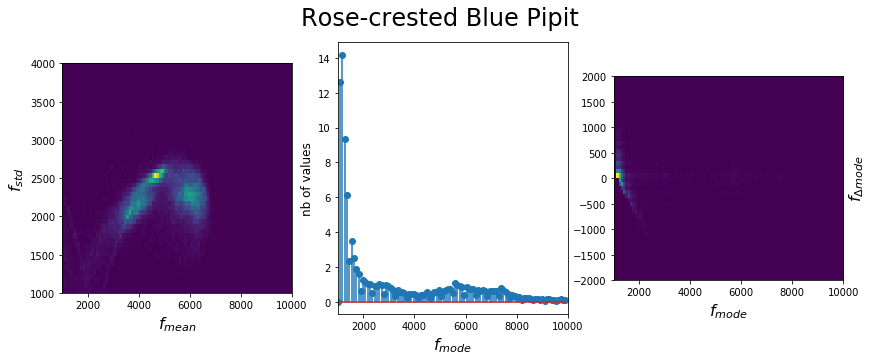

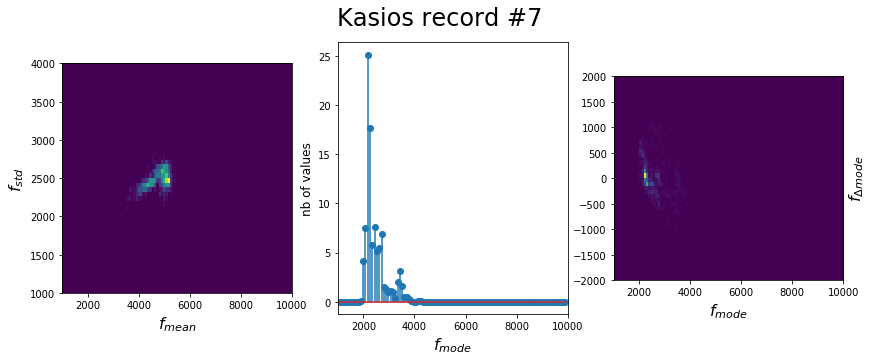

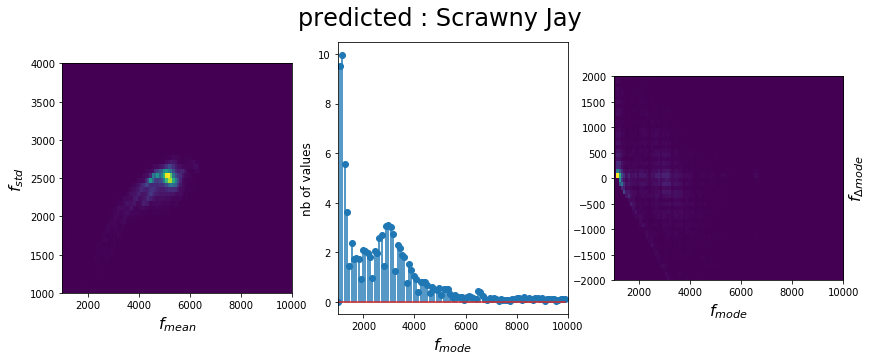

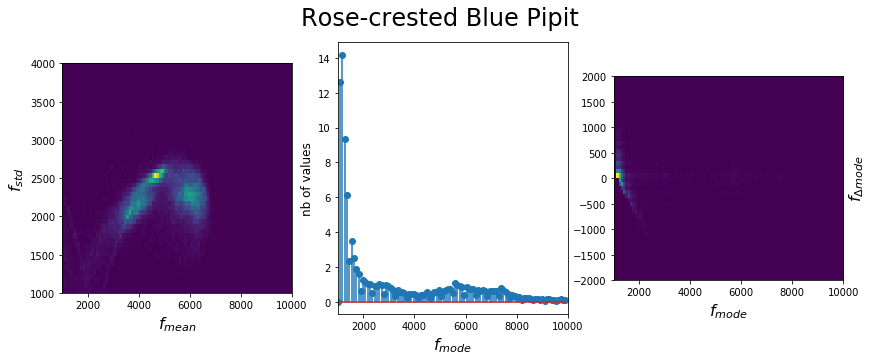

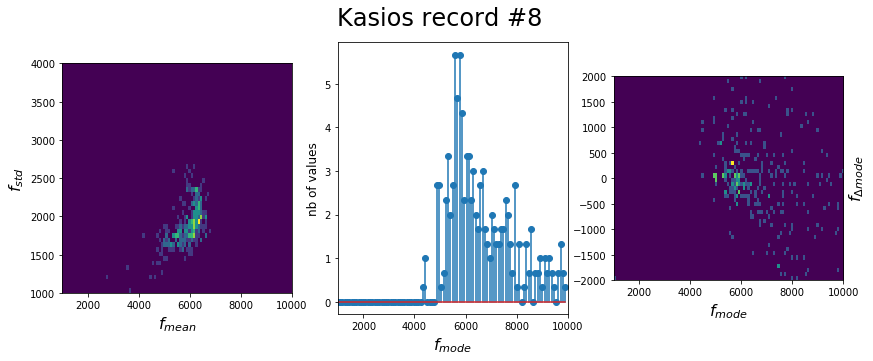

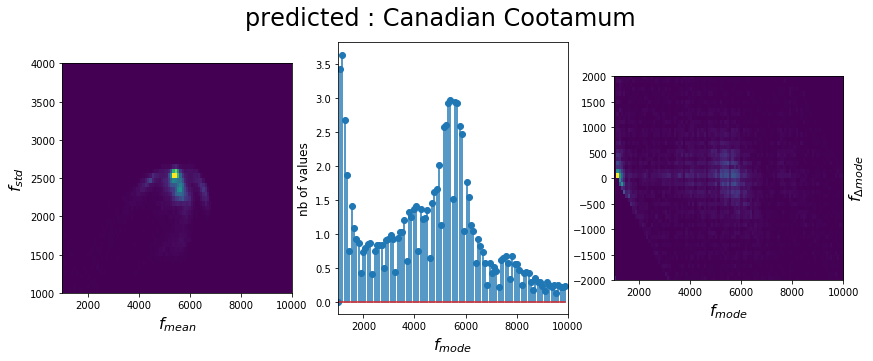

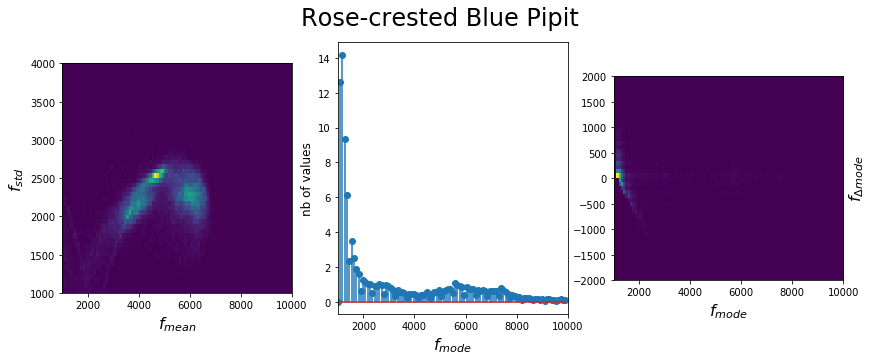

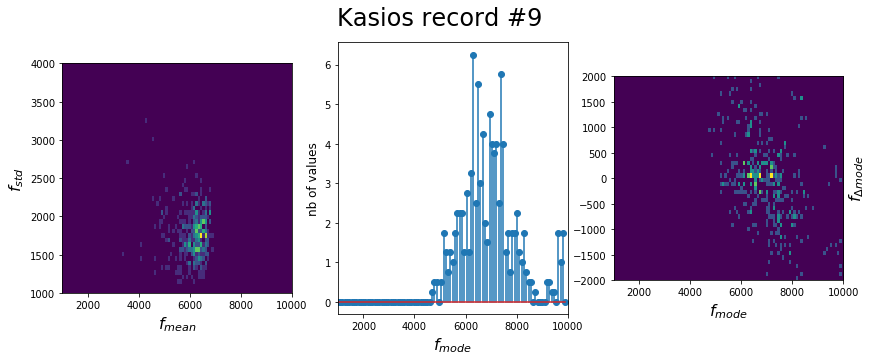

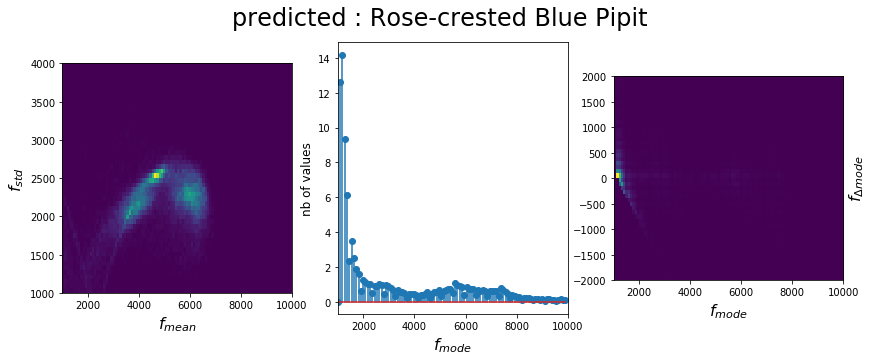

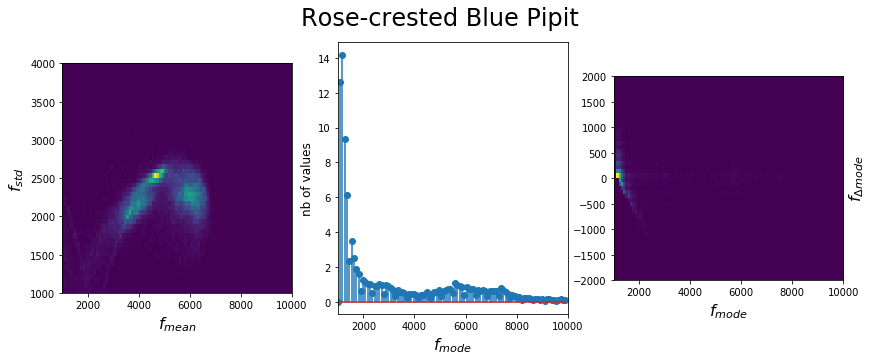

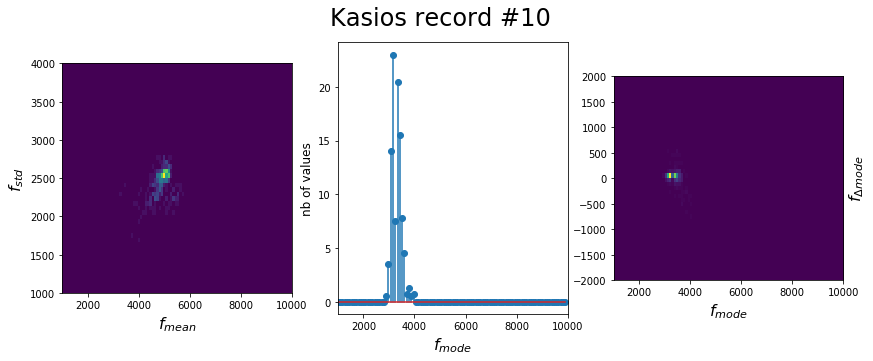

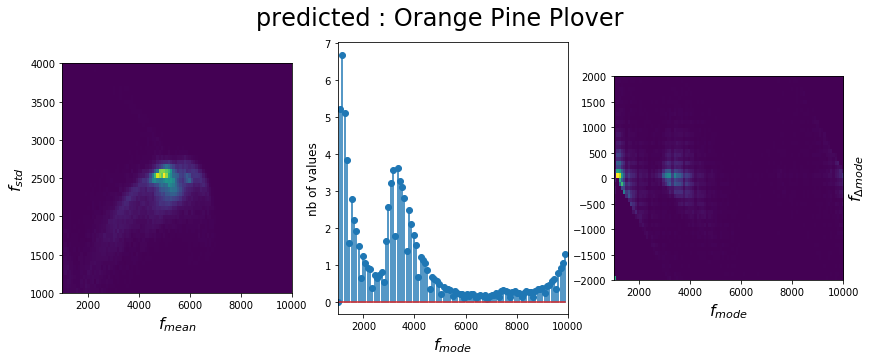

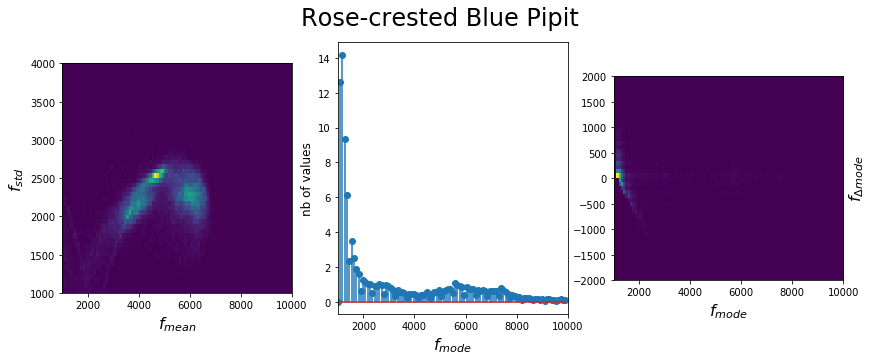

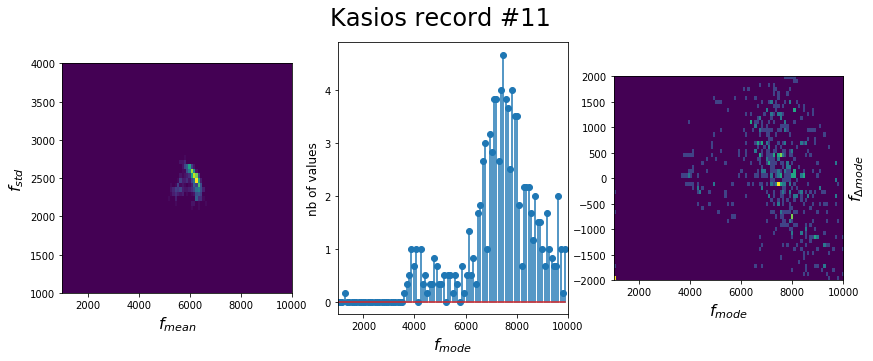

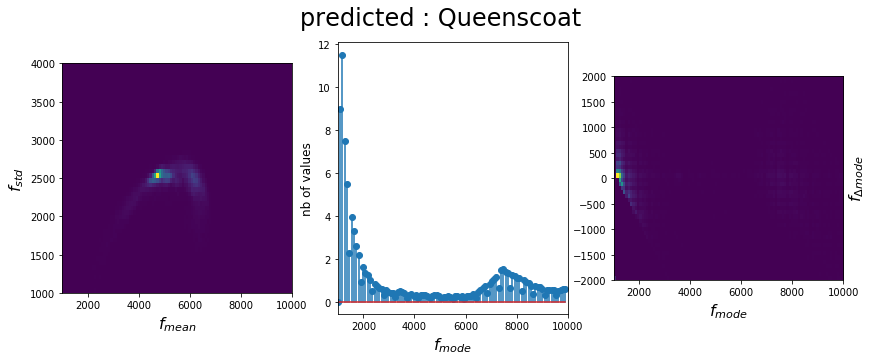

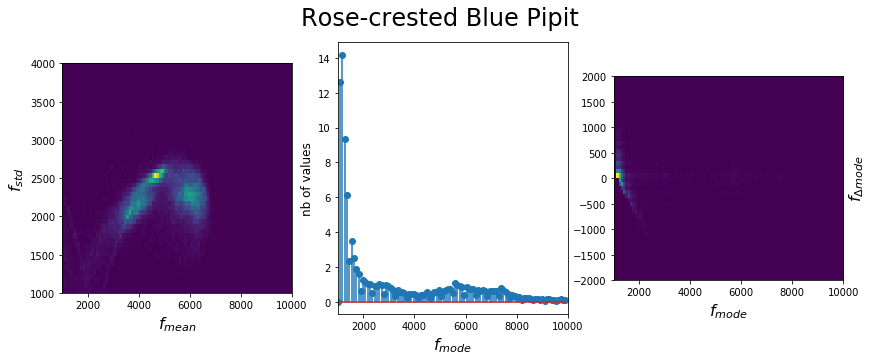

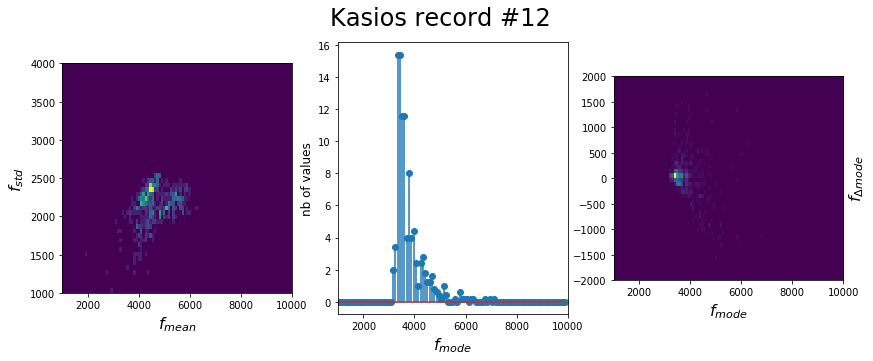

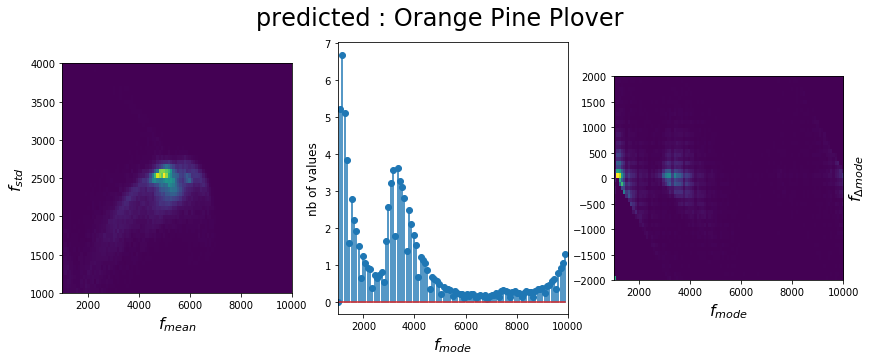

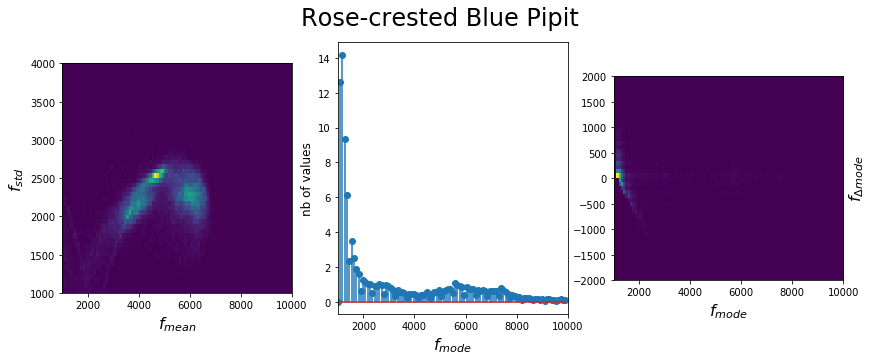

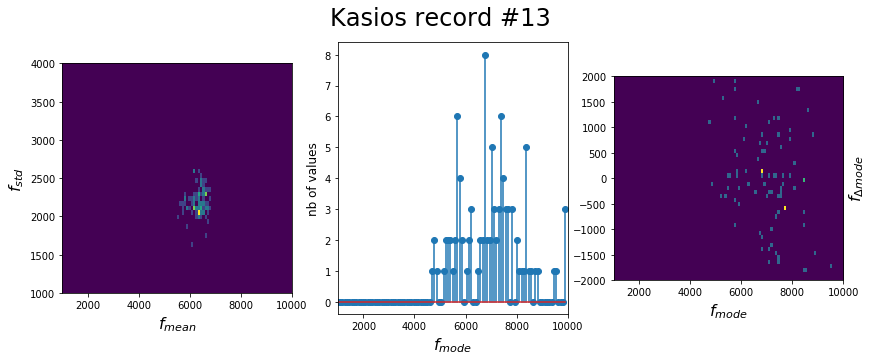

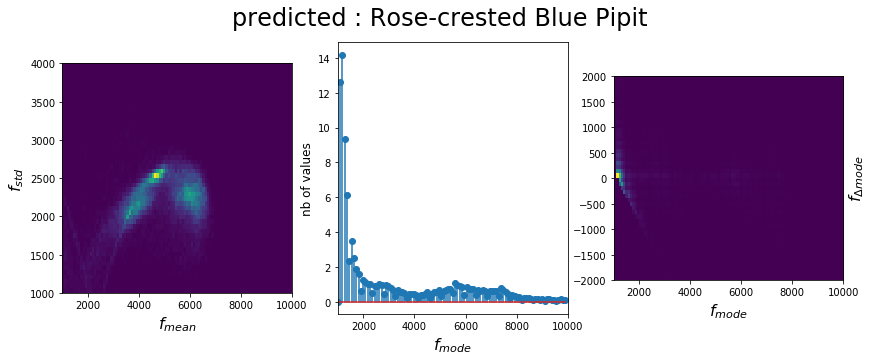

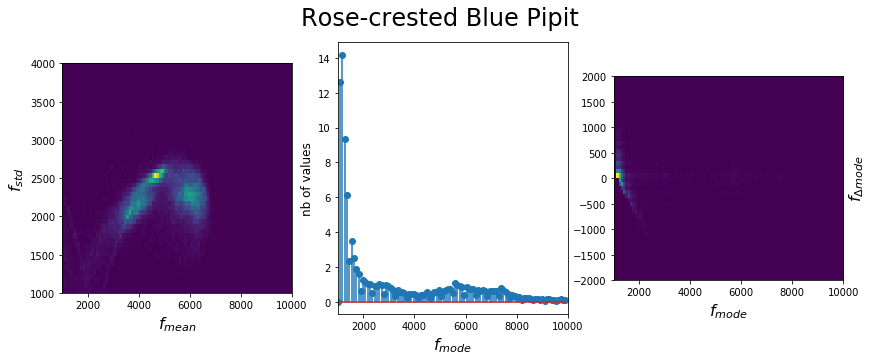

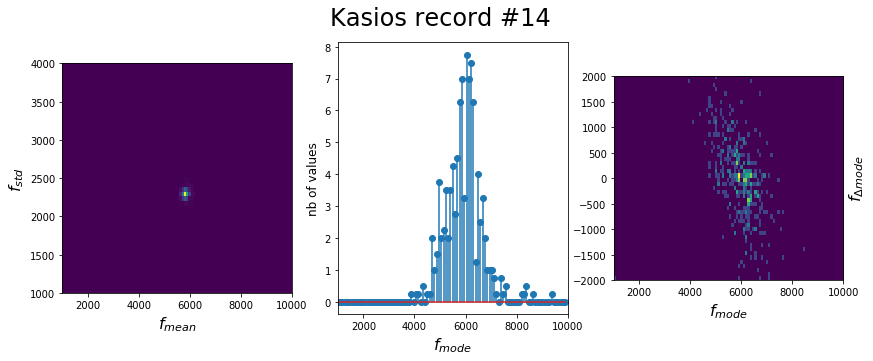

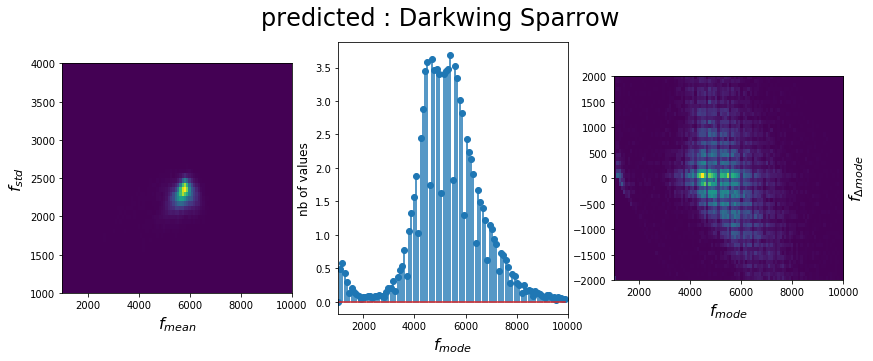

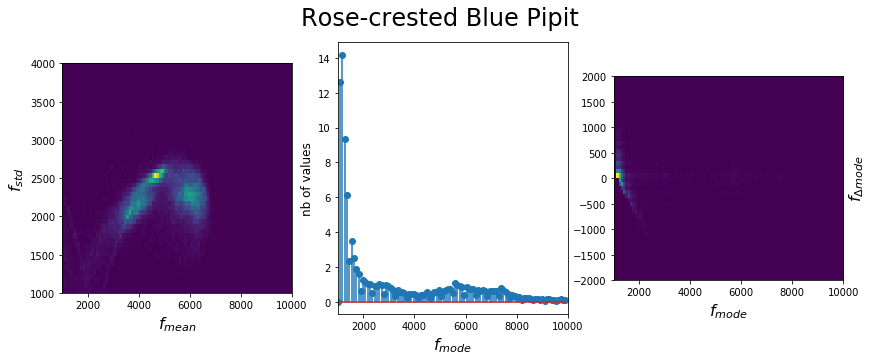

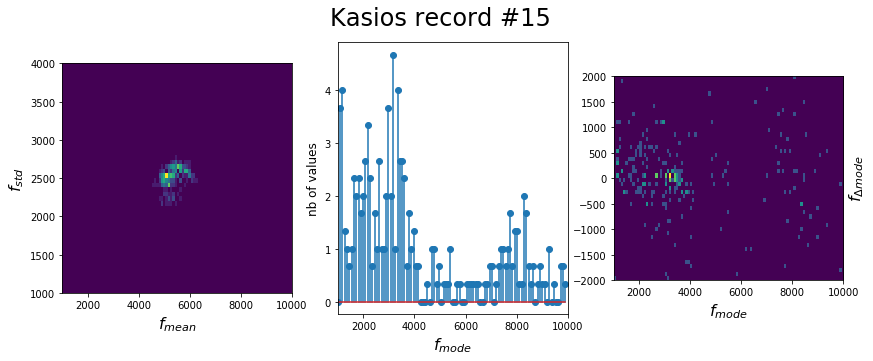

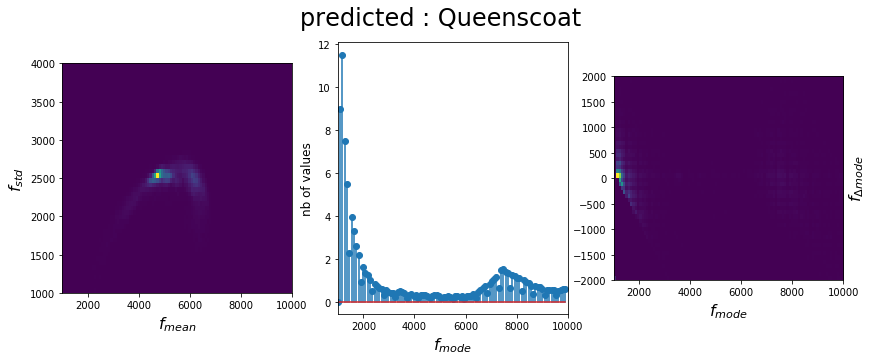

In [126]:
plot_comparaison_predict(predict_kasios)

### With reduced fatures (400 features)

In [142]:
random_forest_red = OneVsRestClassifier(RandomForestClassifier(n_estimators=100, random_state=1))
random_forest_red.fit(X_red_train, y_train)

OneVsRestClassifier(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False),
          n_jobs=None)

In [143]:
random_forest_red.score(X_red_test, y_test)

0.41309523809523807

<div class="alert alert-success">
Lower performance than with histogramms
</div>

## Binary Classification

In [151]:
# create labels with 1 or 0
y_train_oneVSall = y_train.copy()
y_test_oneVSall = y_test.copy()
y_red_train_oneVSall = y_red_train.copy()
y_red_test_oneVSall = y_red_test.copy()
y_train_oneVSall = (y_train_oneVSall == i_bp).replace({True:1,False:0})
y_test_oneVSall = (y_test_oneVSall == i_bp).replace({True:1,False:0})
y_red_train_oneVSall = (y_red_train_oneVSall == i_bp).replace({True:1,False:0})
y_red_test_oneVSall = (y_red_test_oneVSall == i_bp).replace({True:1,False:0})

In [152]:
random_forest3 = RandomForestClassifier(n_estimators=100, random_state=1)
random_forest3.fit(X_train, y_train_oneVSall)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [153]:
random_forest3.score(X_test, y_test_oneVSall)

0.9178571428571428

In [154]:
random_forest3.predict(X_kasios)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0])